<a href="https://colab.research.google.com/github/kilarson/msa/blob/main/msa_cigale.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PHANGS Multiscale stellar associaions pipeline: test

Author: Kirsten Larson (kilarson@stsci.edu), ESA/STScI

Date:
Aug. 13, 2025
Aug. 18, 2025 - updating figures

Using the galaxy NGC 4826 as an example. Testing the cigale step of our msa pipeline




In [79]:
# Import standard data analysis packages
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#Import system/command line packages
import os
from os import path # file management
import sys
import shutil
import time # used to track code runtimes
from datetime import date # used to track date code was run

#Import scipy packages
from scipy import ndimage as ndi
from scipy import stats

# KL: Import astropy packages
from astropy.io import fits
from astropy.wcs import WCS
from astropy.io import ascii
from astropy.table import Table

# JWL: Import other packages
from math import log10, floor
from shlex import split # used to parse command line inputs
import socket # used to get computer hostname



In [80]:
# Import CIGALE packages
#import pcigale
#from pcigale.analysis_modules.pdf_analysis import PdfAnalysis

In [81]:
#galaxy inputs
gal = 'NGC4826'
pc_scales = ['8','16','32','64']
i = 1
distmpc = 4.41
tracer_band = 'nuv'

In [82]:

# Using Google Colab mode?
google_colab = True


if google_colab:
    from google.colab import drive

    # Mount Google Drive
    drive.mount('/content/drive')

    # Now you can access files in your Google Drive, for example:
    # import pandas as pd
    google_dir = '/content/drive/My Drive/PHANGS/NGC4826/'
    dir = google_dir
else:
    dir = '/Users/kilarson/Library/CloudStorage/Box-Box/My Documents - Kirsten Larson/Kirsten_PHANGS/Chris_phangs_msa/NGC4826_cigale/'

data_dir = dir+gal+'_data/'
    # display(df.head())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [83]:
def conv_mjy2ab_mag(flux):

    """conversion of mJy to AB mag.
    See definition on Wikipedia : https://en.wikipedia.org/wiki/AB_magnitude """

    return -2.5 * np.log10(flux * 1e-3) + 8.90


def conv_ab_mag2mjy(mag):

    """conversion of AB mag to mJy.
    See definition on Wikipedia : https://en.wikipedia.org/wiki/AB_magnitude """

    return 1e3 * 10 ** ((8.5 - mag)/2.5)

In [84]:
def conv_vega_mag2ab(vega_mag,filter):

    #if google_colab:
    #    google_dir = '/content/drive/My Drive/PHANGS/NGC4826/'
    #    file_path = google_dir+'header_info_ngc4826_prime.txt'
    #else:
    #dir = '/Users/kilarson/Library/CloudStorage/Box-Box/My Documents - Kirsten Larson/Kirsten_PHANGS/Chris_phangs_msa/NGC4826_cigale/'
    file_path = data_dir+'header_info_ngc4826_prime.txt'

    header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
    filter_list = header_info['filter']
    ab_zp = header_info['zpAB']
    vega_zp = header_info['zpVEGA']

    #filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
    #ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
    #vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

    ab_mag = vega_mag - (vega_zp[filter_list.tolist().index(filter)] - ab_zp[filter_list.tolist().index(filter)])
    return ab_mag


In [85]:
def conv_ab_mag2vega(ab_mag,filter):
      #filter_list = ['F275W', 'F336W', 'F435W', 'F438W', 'F555W', 'F814W']
    #if google_colab:
    #    google_dir = '/content/drive/My Drive/PHANGS/NGC4826/'
    #    file_path = google_dir+'header_info_ngc4826_prime.txt'
    #else:
    #    dir = '/Users/kilarson/Library/CloudStorage/Box-Box/My Documents - Kirsten Larson/Kirsten_PHANGS/Chris_phangs_msa/NGC4826_cigale/'
    file_path = data_dir+'header_info_ngc4826_prime.txt'

    header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
    filter_list = header_info['filter']
    ab_zp = header_info['zpAB']
    vega_zp = header_info['zpVEGA']

    #filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
    #ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
    #vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

    # convert Series to list before using index()
    vega_mag = ab_mag + (vega_zp[filter_list.tolist().index(filter)] - ab_zp[filter_list.tolist().index(filter)])
    return vega_mag

In [86]:
file_path_reg = data_dir+'reg_ha_paa_ebv_nii0p8_iter20250409Masked.fits'
file_path_source =data_dir+'reg_source_base_corrected_nii0p8_4sig_itersub_hole0sigMask.fits'
#df = pd.read_csv(file_path)


#open data file from Chris
#region based extinction correctoin
hdu_list_reg = fits.open(file_path_reg)
hdu_list_reg.info()
# You can access data from specific HDUs like this:
header_reg = hdu_list_reg[1].header
data_reg = hdu_list_reg[1].data
hdu_list_reg.close()



Filename: /content/drive/My Drive/PHANGS/NGC4826/NGC4826_data/reg_ha_paa_ebv_nii0p8_iter20250409Masked.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    108   454R x 45C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, K, D, D, D, D, D, D, D, D, D, D]   


In [87]:
#Source based extinction correctoin
hdu_list_source = fits.open(file_path_source)
hdu_list_source.info()
# You can access data from specific HDUs like this:
header_source = hdu_list_source[1].header
data_source = hdu_list_source[1].data
hdu_list_source.close()

Filename: /content/drive/My Drive/PHANGS/NGC4826/NGC4826_data/reg_source_base_corrected_nii0p8_4sig_itersub_hole0sigMask.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU     82   454R x 37C   [D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D]   


In [88]:
data_reg_tbl = Table(data_reg)
data_reg_df = data_reg_tbl.to_pandas()

print(data_reg_tbl)
data_reg_tbl.colnames

reg_id reg_x  reg_y  ... V_dolmag_vega_new  I_dolmag_vega_new 
------ ------ ------ ... ------------------ ------------------
   1.0 4149.0 2405.0 ... 22.344418383562402 20.866741199111388
   2.0 3342.0 2616.0 ... 22.034104890715888 20.926736920619007
   3.0 3261.0 2690.0 ...  23.36817321920298 21.704956284668363
   4.0 3015.0 2695.0 ... 22.924560053006935  21.41930505984761
   5.0 2997.0 2750.0 ...  22.56710681978563 21.198613838790724
   6.0 3146.0 2767.0 ...   20.5888169912801 19.736833173544127
   7.0 3204.0 2775.0 ...  21.94698419979277 20.723084427620503
   8.0 3488.0 2777.0 ... 22.033875723793606 20.876338100794186
   9.0 3373.0 2787.0 ... 21.196911820125056 19.925088477738097
  10.0 3083.0 2801.0 ...  19.68697644853575 18.707042752434422
   ...    ...    ... ...                ...                ...
 445.0 4831.0 4659.0 ... 19.253615745219783 19.889886846338154
 446.0 4700.0 4664.0 ...  17.49767618663398  18.74959385976317
 447.0 4527.0 4694.0 ... 19.212701537464827  19.9468656

['reg_id',
 'reg_x',
 'reg_y',
 'reg_ra',
 'reg_dec',
 'reg_area',
 'reg_rad',
 'NUV_dolflux_mjy',
 'NUV_dolflux_mjy_err',
 'U_dolflux_mjy',
 'U_dolflux_mjy_err',
 'B_dolflux_mjy',
 'B_dolflux_mjy_err',
 'V_dolflux_mjy',
 'V_dolflux_mjy_err',
 'I_dolflux_mjy',
 'I_dolflux_mjy_err',
 'NUV_dolmag_vega',
 'NUV_dolmag_vega_err',
 'U_dolmag_vega',
 'U_dolmag_vega_err',
 'B_dolmag_vega',
 'B_dolmag_vega_err',
 'V_dolmag_vega',
 'V_dolmag_vega_err',
 'I_dolmag_vega',
 'I_dolmag_vega_err',
 'reg_dolflux_Age_MinChiSq',
 'reg_dolflux_Age_MinChiSq_err',
 'reg_dolflux_Mass_MinChiSq',
 'reg_dolflux_Mass_MinChiSq_err',
 'reg_dolflux_Ebv_MinChiSq',
 'reg_dolflux_Ebv_MinChiSq_err',
 'reg_dolflux_ChiSq_Reduced',
 'reg_n_pixel',
 'reg_H_alpha_Luminosity',
 'reg_Pa_alpha_Luminosity',
 'reg_ratio_H_alpha_to_Pa_alpha',
 'reg_ebv_from_ratio',
 'reg_av_from_ratio',
 'NUV_dolmag_vega_new',
 'U_dolmag_vega_new',
 'B_dolmag_vega_new',
 'V_dolmag_vega_new',
 'I_dolmag_vega_new']

In [89]:
data_tbl = Table(data_source)
data_source_df = data_tbl.to_pandas()

print(data_tbl)
data_tbl.colnames

reg_id reg_x  reg_y  ... V_dolflux_mjy_err_old  I_dolflux_mjy_err_old 
------ ------ ------ ... ---------------------- ----------------------
   1.0 4149.0 2405.0 ... 0.00014264886757225115 0.00025006095595270494
   2.0 3342.0 2616.0 ...  8.122446898774364e-05 0.00014952195461254367
   3.0 3261.0 2690.0 ... 0.00010093798197396456 0.00018535649442210026
   4.0 3015.0 2695.0 ... 0.00011661112470877605 0.00021009207888481033
   5.0 2997.0 2750.0 ... 0.00013830622950815262 0.00023800613034391952
   6.0 3146.0 2767.0 ...  0.0002907921488755078 0.00046662487398233725
   7.0 3204.0 2775.0 ... 0.00017549421381386039  0.0002907266519419101
   8.0 3488.0 2777.0 ... 0.00016026621149731575 0.00027238912959301167
   9.0 3373.0 2787.0 ... 0.00024237576877408052  0.0004085565814095552
  10.0 3083.0 2801.0 ... 0.00034983889694316004  0.0005642889085450147
   ...    ...    ... ...                    ...                    ...
 445.0 4831.0 4659.0 ...  0.0001069481584117506 0.00018465801813582426
 446.0

['reg_id',
 'reg_x',
 'reg_y',
 'reg_ra',
 'reg_dec',
 'reg_area',
 'reg_rad',
 'NUV_dolmag_vega',
 'U_dolmag_vega',
 'B_dolmag_vega',
 'V_dolmag_vega',
 'I_dolmag_vega',
 'NUV_dolflux_mjy',
 'U_dolflux_mjy',
 'B_dolflux_mjy',
 'V_dolflux_mjy',
 'I_dolflux_mjy',
 'NUV_dolflux_mjy_err',
 'U_dolflux_mjy_err',
 'B_dolflux_mjy_err',
 'V_dolflux_mjy_err',
 'I_dolflux_mjy_err',
 'NUV_dolmag_vega_old',
 'U_dolmag_vega_old',
 'B_dolmag_vega_old',
 'V_dolmag_vega_old',
 'I_dolmag_vega_old',
 'NUV_dolflux_mjy_old',
 'U_dolflux_mjy_old',
 'B_dolflux_mjy_old',
 'V_dolflux_mjy_old',
 'I_dolflux_mjy_old',
 'NUV_dolflux_mjy_err_old',
 'U_dolflux_mjy_err_old',
 'B_dolflux_mjy_err_old',
 'V_dolflux_mjy_err_old',
 'I_dolflux_mjy_err_old']

In [16]:
# -------
infile_SSP=data_dir+'models-block-bc03-0cov.txt'
#read in model data
#;; BC03 models
#readcol,'models-block-bc03-0cov.txt',
#format='(i,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d)',bc03id ,bc03F275W_1 ,bc03F275W_2 ,bc03F336W_1 ,bc03F336W_2 ,bc03F435W_acs ,
#bc03F438W_1 ,bc03F438W_2 ,bc03F555W_ACS ,bc03F555W_1 ,bc03F555W_2 ,bc03F814W_ACS ,bc03F814W_1 ,bc03F814W_1 ,bc03mstar,bc03age
#;; convert mjy to vega mag
#infile_SSP='models-block-bc03-0cov.txt'
#bc03=pd.read_csv(infile_SSP, header=0,converters={'clumpSFRerr':np.float,'age_err':np.float,'mass_err':np.float}, delim_whitespace= True)
bc03=pd.read_csv(infile_SSP, header=0, delim_whitespace= True)


filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

bc03_U_ab = -2.5 * np.log10( bc03['F336W_UVIS_CHIP2']* np.power(10.,-29) ) - 48.60
bc03_U_vega = conv_ab_mag2vega(bc03_U_ab,"F336W")
#bc03_U_vega = bc03_U_ab + (vega_zp[0] - ab_zp[0])

bc03_B_ab = -2.5 * np.log10( bc03['F438W_UVIS_CHIP2']*np.power(10.,-29) ) -48.60
#bc03_B_vega = bc03_B_ab + (vega_zp[1] - ab_zp[1])
bc03_B_vega = conv_ab_mag2vega(bc03_B_ab,"F438W")

bc03_V_ab = -2.5 * np.log10( bc03['F555W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
#bc03_V_vega = bc03_V_ab + (vega_zp[2] - ab_zp[2])
bc03_V_vega = conv_ab_mag2vega(bc03_V_ab,"F555W")

bc03_I_ab = -2.5 * np.log10( bc03['F814W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
#bc03_I_vega = bc03_I_ab + (vega_zp[3] - ab_zp[3])
bc03_I_vega = conv_ab_mag2vega(bc03_I_ab,"F814W")
#;;--------

bc03

/tmp/ipython-input-2759369067.py:11: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  bc03=pd.read_csv(infile_SSP, header=0, delim_whitespace= True)


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/My Drive/PHANGS/NGC4826/NGC4826_data/models-block-bc03-0cov.txt'

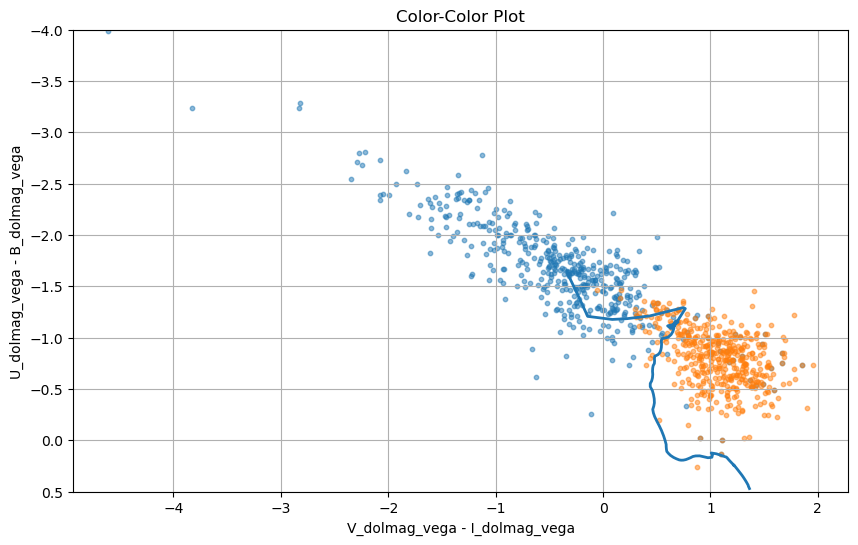

In [ ]:
# Calculate color indices
v_i_color = data_reg_tbl['V_dolmag_vega'] - data_reg_tbl['I_dolmag_vega']
u_b_color = data_reg_tbl['U_dolmag_vega'] - data_reg_tbl['B_dolmag_vega']

v_i_color_new = data_reg_tbl['V_dolmag_vega_new'] - data_reg_tbl['I_dolmag_vega_new']
u_b_color_new = data_reg_tbl['U_dolmag_vega_new'] - data_reg_tbl['B_dolmag_vega_new']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5)
plt.scatter(v_i_color,u_b_color, s=10, alpha=0.5)
plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-4)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt.title('Color-Color Plot')
plt.grid(True)
plt.show()

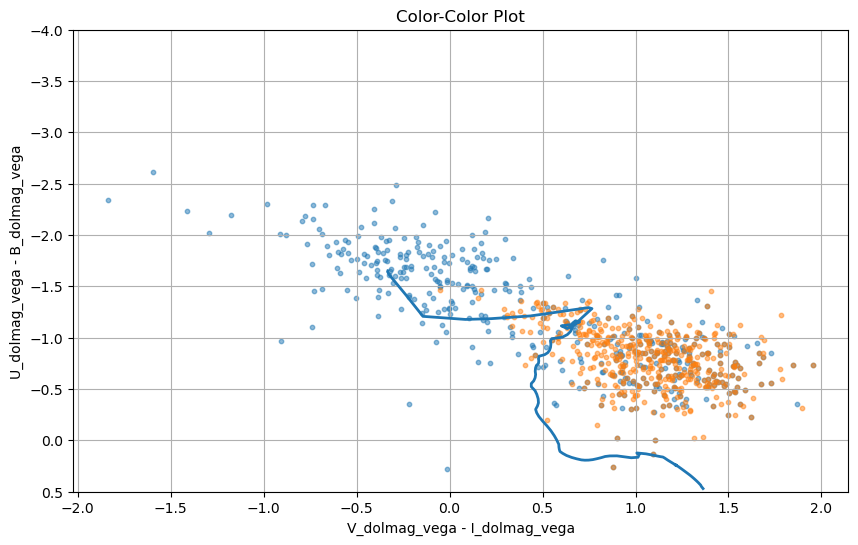

In [ ]:
# Calculate color indices
v_i_color = data_tbl['V_dolmag_vega_old'] - data_tbl['I_dolmag_vega_old']
u_b_color = data_tbl['U_dolmag_vega_old'] - data_tbl['B_dolmag_vega_old']

v_i_color_new = data_tbl['V_dolmag_vega'] - data_tbl['I_dolmag_vega']
u_b_color_new = data_tbl['U_dolmag_vega'] - data_tbl['B_dolmag_vega']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5)
plt.scatter(v_i_color,u_b_color, s=10, alpha=0.5)
plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-4)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt.title('Color-Color Plot')
plt.grid(True)
plt.show()

In [90]:
#need to read-in for cigale_pipe3
#reginfo and
#dolphot photometry -> update this file with Chris's measurements then run pipe3

pipefile = data_dir+'PHANGS_IR4_hst_wfc3_ngc4826_v1p3_multi_assoc-nuvselect-ws16pc-main.fits'
pipe_tbl = Table.read(pipefile, format='fits')
pipe_df = pipe_tbl.to_pandas()

pipe_tbl

reg_id,reg_x,reg_y,reg_ra,reg_dec,reg_area,reg_rad,NUV_dolflux_mjy,NUV_dolflux_mjy_err,U_dolflux_mjy,U_dolflux_mjy_err,B_dolflux_mjy,B_dolflux_mjy_err,V_dolflux_mjy,V_dolflux_mjy_err,I_dolflux_mjy,I_dolflux_mjy_err,NUV_dolmag_vega,NUV_dolmag_vega_err,U_dolmag_vega,U_dolmag_vega_err,B_dolmag_vega,B_dolmag_vega_err,V_dolmag_vega,V_dolmag_vega_err,I_dolmag_vega,I_dolmag_vega_err,reg_dolflux_Age_MinChiSq,reg_dolflux_Age_MinChiSq_err,reg_dolflux_Mass_MinChiSq,reg_dolflux_Mass_MinChiSq_err,reg_dolflux_Ebv_MinChiSq,reg_dolflux_Ebv_MinChiSq_err,reg_dolflux_ChiSq_Reduced
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1.0,4149.0,2405.0,194.17805562806927,21.66817000011486,476.4303538512865,12.314726619332893,0.001699323198416626,9.086919555850587e-05,0.002448792838421668,0.00011785189764138915,0.003510068541030133,0.00014423483225357064,0.004255439024845925,0.00014264886757225115,0.011035203967131417,0.00025006095595270494,21.77584818629281,0.05828639499011169,21.733294435804325,0.052457915758978686,22.67420600597371,0.044789999203335304,22.344418383562402,0.03653847810905561,20.866741199111388,0.024699719443364458,9.0,1.0,1505.163895247256,25.87,0.42,0.05,0.9958343790068137
2.0,3342.0,2616.0,194.18761253969285,21.670491999626197,302.79158030910077,9.817410731226436,0.0010433347859270246,4.260296477892622e-05,0.0016330736814443422,5.7148895163149764e-05,0.005535444264920187,9.713486887115406e-05,0.005663302623298223,8.122446898774364e-05,0.010441961224849798,0.00014952195461254367,22.305478933221984,0.044508466731289074,22.17316010253344,0.038144204046408954,22.179613792699634,0.01912710199984003,22.034104890715888,0.015633046136792755,20.926736920619007,0.015608076588123609,127.0,9.0,9202.755559019994,1099.977,0.32,0.02,2.896885274574161
3.0,3261.0,2690.0,194.18857183591226,21.671306363147643,281.2661125146149,9.462017980424912,0.0006758259766431735,4.906139801936609e-05,0.0007751380884075021,6.387827546594067e-05,0.0013176238271084934,0.00010178430321255953,0.0016574576395344798,0.00010093798197396456,0.005099109409546076,0.00018535649442210026,22.77695095020411,0.07912824556808076,22.98222685803005,0.08982569854220758,23.738016399116496,0.0842007318167256,23.36817321920298,0.0663802185511798,21.70495628466836,0.03962232670313987,10.0,0.0,832.7955495341234,135.399,0.47000000000000003,0.05,1.673450940352927
4.0,3015.0,2695.0,194.19148512472734,21.671361212790874,420.4641375856233,11.568832775143976,0.0011849219242417788,6.7858446810657e-05,0.0018088731785123918,9.52661214550275e-05,0.0023869789362683763,0.00011847550837748877,0.0024939497814888763,0.00011661112470877605,0.00663368462185935,0.00021009207888481033,22.167313814001684,0.06242243097235806,22.062154253990716,0.05740594399844965,23.09287353193731,0.05410114943592586,22.924560053006935,0.05096579204441084,21.41930505984761,0.03452084008182122,9.0,1.0,811.0747631819944,16.65,0.37,0.05,2.962116166797271
5.0,2997.0,2750.0,194.19169834185146,21.671966503267118,416.1590440267261,11.50945428499989,0.0013031417966160987,6.827674312782267e-05,0.0014536049274465734,9.726631213729629e-05,0.0028742695660238337,0.00014067593411266536,0.0034663227500032695,0.00013830622950815262,0.008128891163734457,0.00023800613034391952,22.06405896578758,0.05710940298483197,22.299558585812374,0.07293610404574642,22.891176257449196,0.053348081890219536,22.56710681978563,0.0434909848379653,21.19861383879072,0.031914153707981285,11.0,8.0,1344.0303426443497,1453.656,0.41000000000000003,0.04,0.9638718854678884
6.0,3146.0,2767.0,194.18993379662223,21.67215371391705,1485.2572778195226,21.74332253949196,0.02007628603243027,0.00019611378960964344,0.020107947283290635,0.00022870242592032327,0.02285762750817526,0.0003010220854513485,0.021438032694136428,0.0002907921488755078,0.03124234148424092

In [ ]:
#Convert Vega mag from data file into mJy
#Create input data file for Cigale for Av corrected data

num_markers =len(data_tbl['B_dolflux_mjy'])
outdir = data_dir

#--------------
nuv_dolflux_ab_source = conv_vega_mag2ab(data_tbl['NUV_dolmag_vega'],"F275W")
u_dolflux_ab_source = conv_vega_mag2ab(data_tbl['U_dolmag_vega'],"F336W")
b_dolflux_ab_source = conv_vega_mag2ab(data_tbl['B_dolmag_vega'],"F438W")
v_dolflux_ab_source = conv_vega_mag2ab(data_tbl['V_dolmag_vega'],"F555W")
i_dolflux_ab_source = conv_vega_mag2ab(data_tbl['I_dolmag_vega'],"F814W")

nuv_dolflux_mJy = conv_ab_mag2mjy(nuv_dolflux_ab_source)
u_dolflux_mJy = conv_ab_mag2mjy(u_dolflux_ab_source)
b_dolflux_mJy = conv_ab_mag2mjy(b_dolflux_ab_source)
v_dolflux_mJy = conv_ab_mag2mjy(v_dolflux_ab_source)
i_dolflux_mJy = conv_ab_mag2mjy(i_dolflux_ab_source)

nuv_dolflux_mJy_err = pipe_tbl['NUV_dolflux_mjy_err']
u_dolflux_mJy_err = pipe_tbl['U_dolflux_mjy_err']
b_dolflux_mJy_err = pipe_tbl['B_dolflux_mjy_err']
v_dolflux_mJy_err = pipe_tbl['V_dolflux_mjy_err']
i_dolflux_mJy_err = pipe_tbl['I_dolflux_mjy_err']

nuv_cig_filt = 'hst.wfc3.uvis2.F275W'
u_cig_filt = 'hst.wfc3.uvis2.F336W'
b_cig_filt = 'hst.wfc3.uvis2.F438W'
v_cig_filt = 'hst.wfc3.uvis2.F555W'
i_cig_filt = 'hst.wfc3.uvis2.F814W'
#
#--------------------------------
#Save cigale file
#--------------------------------
#data output for cigale fitting in proper format.
cig_redshift  = np.zeros(num_markers)
cig_distance  = np.full(num_markers, fill_value=distmpc)

t_cig = Table([data_tbl['reg_id'],cig_redshift,cig_distance,
        nuv_dolflux_mJy,nuv_dolflux_mJy_err,u_dolflux_mJy,u_dolflux_mJy_err,b_dolflux_mJy,b_dolflux_mJy_err,
        v_dolflux_mJy,v_dolflux_mJy_err,i_dolflux_mJy,i_dolflux_mJy_err],

      names=('id','redshift','distance',nuv_cig_filt, nuv_cig_filt+'_err',u_cig_filt, u_cig_filt+'_err',
          b_cig_filt, b_cig_filt+'_err', v_cig_filt , v_cig_filt+'_err',i_cig_filt , i_cig_filt+'_err'),

      #meta={'ws_data':self.gal+' smoothing scale [pc]:'+str(int(pc_scales[i])) })
      meta={'ws_data':gal+' smoothing scale [pc]:'+str(int(pc_scales[i])) })


#fits.writeto(outdir+'Dolphot_catalog'+str(int(pc_scales[i]))+'.fits', np.array(t))
df_cig = t_cig.to_pandas()

#replace 0 values with -9999
df_cig.replace([0.0], -9999.0, inplace=True)
df_cig[df_cig < 0] = -9999.0

df_cig['redshift'] = 0.0
cig_file = '{0}_{1}_msa{2}pc_Dolphot_mjy_cigfile.tab'.format(gal,tracer_band,pc_scales[i])
#cig_file = gal+'_'+tracer_band+'_ws'+str(int(pc_scales[i]))+'pc_Dolphot_mjy_cigfile.tab'

df_cig.to_csv(outdir+cig_file,sep=' ',index=False)
#--------------------------------

/var/folders/c1/z2gc04tj77sdn7xt1014zjz00002sw/T/ipykernel_94956/1886640241.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/var/folders/c1/z2gc04tj77sdn7xt1014zjz00002sw/T/ipykernel_94956/1886640241.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/var/folders/c1/z2gc04tj77sdn7xt1014zjz00002sw/T/ipykernel_94956/1886640241.py:10: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  header_info = pd.read_csv(file_path, header=0, delim_whitespace= True)
/var/folders/c1/z2gc04tj77sdn7xt1014zjz00002sw/T/ipykernel_94956/1886640241.py:10: FutureWarning: The 'del

In [ ]:
# Create input data file for Cigale for original data
#Convert Vega mag from data file into mJy


num_markers =len(data_tbl['B_dolflux_mjy'])
outdir = data_dir

#--------------

nuv_dolflux_mJy = pipe_tbl['NUV_dolflux_mjy']
u_dolflux_mJy = pipe_tbl['U_dolflux_mjy']
b_dolflux_mJy = pipe_tbl['B_dolflux_mjy']
v_dolflux_mJy = pipe_tbl['V_dolflux_mjy']
i_dolflux_mJy = pipe_tbl['I_dolflux_mjy']

nuv_dolflux_mJy_err = pipe_tbl['NUV_dolflux_mjy_err']
u_dolflux_mJy_err = pipe_tbl['U_dolflux_mjy_err']
b_dolflux_mJy_err = pipe_tbl['B_dolflux_mjy_err']
v_dolflux_mJy_err = pipe_tbl['V_dolflux_mjy_err']
i_dolflux_mJy_err = pipe_tbl['I_dolflux_mjy_err']

nuv_cig_filt = 'hst.wfc3.uvis2.F275W'
u_cig_filt = 'hst.wfc3.uvis2.F336W'
b_cig_filt = 'hst.wfc3.uvis2.F438W'
v_cig_filt = 'hst.wfc3.uvis2.F555W'
i_cig_filt = 'hst.wfc3.uvis2.F814W'
#
#--------------------------------
#Save cigale file
#--------------------------------
#data output for cigale fitting in proper format.
cig_redshift  = np.zeros(num_markers)
cig_distance  = np.full(num_markers, fill_value=distmpc)

t_cig = Table([data_tbl['reg_id'],cig_redshift,cig_distance,
        nuv_dolflux_mJy,nuv_dolflux_mJy_err,u_dolflux_mJy,u_dolflux_mJy_err,b_dolflux_mJy,b_dolflux_mJy_err,
        v_dolflux_mJy,v_dolflux_mJy_err,i_dolflux_mJy,i_dolflux_mJy_err],

      names=('id','redshift','distance',nuv_cig_filt, nuv_cig_filt+'_err',u_cig_filt, u_cig_filt+'_err',
          b_cig_filt, b_cig_filt+'_err', v_cig_filt , v_cig_filt+'_err',i_cig_filt , i_cig_filt+'_err'),

      #meta={'ws_data':self.gal+' smoothing scale [pc]:'+str(int(pc_scales[i])) })
      meta={'ws_data':gal+' smoothing scale [pc]:'+str(int(pc_scales[i])) })


#fits.writeto(outdir+'Dolphot_catalog'+str(int(pc_scales[i]))+'.fits', np.array(t))
df_cig = t_cig.to_pandas()

#replace 0 values with -9999
df_cig.replace([0.0], -9999.0, inplace=True)
df_cig[df_cig < 0] = -9999.0

df_cig['redshift'] = 0.0
cig_file = '{0}_{1}_msa{2}pc_original_Dolphot_mjy_cigfile.tab'.format(gal,tracer_band,pc_scales[i])
#cig_file = gal+'_'+tracer_band+'_ws'+str(int(pc_scales[i]))+'pc_Dolphot_mjy_cigfile.tab'

df_cig.to_csv(outdir+cig_file,sep=' ',index=False)

In [ ]:
data_tbl['reg_id']

1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0


In [ ]:
data_reg_tbl['reg_Pa_alpha_Luminosity']

3.1182404204794787e+35
2.202184402234461e+35
1.0869135595561585e+35
1.0675363533568715e+35
1.196098206316857e+35
7.002778776264471e+35
3.624414030300889e+35
5.344957509690852e+35
5.9843755398808546e+35
1.1803008685339044e+36
8.662357909764555e+35


In [ ]:
print(data_reg_tbl['reg_Pa_alpha_Luminosity'])
print(data_reg_tbl['reg_H_alpha_Luminosity'])


reg_Pa_alpha_Luminosity
-----------------------
 3.1182404204794787e+35
  2.202184402234461e+35
 1.0869135595561585e+35
 1.0675363533568715e+35
  1.196098206316857e+35
  7.002778776264471e+35
  3.624414030300889e+35
  5.344957509690852e+35
 5.9843755398808546e+35
 1.1803008685339044e+36
                    ...
  3.453406679948699e+35
  3.905356333402746e+35
  3.638836874371475e+35
 4.4482714165375176e+35
  2.409732424695295e+36
  1.371552133579598e+36
  3.782025537931505e+35
 3.6224751057254014e+35
  4.026176453723665e+35
                    0.0
Length = 454 rows
 reg_H_alpha_Luminosity
-----------------------
 -2.306444908413302e+35
 -1.465842999021707e+35
-1.3616361507500216e+35
  -2.03550710290692e+35
 -2.014665733252583e+35
  -7.19027253074629e+35
 -3.372828322393548e+35
-2.8274791497717287e+35
-4.8213035133699745e+35
-1.0379002087859857e+36
                    ...
 2.8730754561982057e+35
 1.3729595585071889e+35
 3.3285925309601346e+35
  5.349219088974599e+35
  9.219235202915823e+3

## Cigale pipeline


In [ ]:
# ------------------------------
#  Define CIGALE output folder
# ------------------------------
outdir = data_dir
cigdir = 'out/'
cigale_file = 'results'
cigdir_new = outdir+'Cigale_outs/'
bayes_output_path = cigdir_new+'bayesian_analysis_output/'
# -------
#infile_SSP=datadir+'models-block-bc03-0cov.txt'

# ------------------------------
#   check for output directory
# ------------------------------
if (path.exists(cigdir_new)==True):
    print('Output directory: '+cigdir_new +' already exists')
if (path.exists(cigdir_new)==False):
    os.mkdir(cigdir_new)
    print("Output Directory '% s' created" % cigdir_new)
# ------------------------------

Output directory: /Users/kilarson/Library/CloudStorage/Box-Box/My Documents - Kirsten Larson/Kirsten_PHANGS/Chris_phangs_msa/NGC4826_cigale/NGC4826_data/Cigale_outs/ already exists


In [ ]:
# JWL: Initialize CIGALE stats file
statfile_name = '{0}{1}_{2}_Cigale_stats.txt'.format(cigdir_new,gal,tracer_band)
#statfile_name = cigdir_new+gal+'_'+tracer_band+'_hpfilt'+filter_step+'_Cigale_stats.txt'
statfile = open(statfile_name,'w')
statfile.write(cigdir_new+'\n')
statfile.write('Galaxy:  {0}\n'.format(gal))
#statfile.write('Dolphot file:  {0}\n'.format(self.dolphot_combfile))
statfile.write('Tracer star band: {0}\n'.format(tracer_band))
#statfile.write('Smoothing step: {0}\n'.format(self.filter_step))

# JWL: Begin tracking runtime
program_start_time = time.time()

#---------------------------------
# check the distance and re-set scale levels
# Cigale step will fail is there are no regions at a given level.
pc_scales = ['8','16','32','64']
n_scales = len(pc_scales)
if (distmpc > 17.0):
    pc_scales = ['16','32','64']
    n_scales = len(pc_scales)
    min_scale_pc = 16 # minimum scale length set in parsecs
    nlevels = n_scales #number of hierarchy levels to compute


statfile.write('pc level, med Age (.25Q,.75Q), med Mass (.25Q,.75Q), med E(B-V) (.25Q,.75Q), med nDolphot (.25Q,.75Q), med NUV dolMag (.25Q,.75Q), med M_V abs(Mag) (.25Q,.75Q) \n')


161

In [ ]:
# edit for only one scale
pc_scales = ['16']
n_scales = len(pc_scales)
nlevels = n_scales
i=0

In [ ]:
# create a fit_specs_dictionary like cluster code:
ebv_start = 0.0
ebv_end = 1.5
ebv_step = 0.01
phangs_def_ebv = np.arange(ebv_start, ebv_end+ebv_step, step=0.01)
#calculate attenuation at V-band (550 nm) from E(b-v) for dustextPHANGS
phangs_A550 = 3.1*phangs_def_ebv

fit_specs_dictionary = {
    'cores': 4,
    'metallicity': [0.02],
    'age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
            14, 15, 16, 18, 19, 21, 22, 24, 26, 28, 30,
            32, 34, 37, 40, 43, 46, 49, 53, 57, 61, 66,
            71, 76, 82, 88, 95, 102, 110, 118, 127, 136,
            147, 158, 169, 182, 196, 210, 226, 243, 261,
            281, 302, 324, 349, 375, 403, 433, 465, 500,
            537, 577, 621, 667, 717, 770, 828, 890, 956,
            1028, 1105, 1187, 1276, 1371, 1474, 1584,
            1702, 1829, 1966, 2113, 2271, 2440, 2623,
            2819, 3029, 3255, 3499, 3760, 4041, 4343,
            4667, 5015, 5390, 5793, 6225, 6690, 7190,
            7727, 8304, 8925, 9591, 10308, 11077,
            11905, 12794, 13650],
    'E_BV': phangs_def_ebv,
    'A550': phangs_A550,



}

# galaxy_props_dict = {'galaxy_id': 'ngc1566',
#                      'galaxy_distance': 10.0,
#                      'galaxy_redshift': 0.0,
#                      'galaxy_filters': ['F---W_UVIS_CHIP2', 'F---W_UVIS_ACS']}  # see param list above

galaxy_props_dict = {'galaxy_id': 'ngc4826',
                     'galaxy_distance': 4.6,
                     'galaxy_redshift': 0.0,
                    }

"""Get a list of filter id's without _err"""
#target_filters_without_err = [filt_raw for filt_raw in galaxy_props_dictionary['galaxy_filters'] if '_err' not in filt_raw]
"""Generate the CIGALE string needed for the dustext dictionary"""

cig_input_file = gal+'_'+tracer_band+'_msa'+pc_scales[i]+'pc_Dolphot_mjy_cigfile.tab'
cig_input = pd.read_csv(outdir+cig_input_file,sep=' ')
cig_input_col = list(cig_input.columns.values)
cig_input_filters = cig_input_col[3:13]
print(cig_input_filters)
print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
                                                             cig_input_filters[8]])
cig_filt_str = cig_input_filters[0]+' & '+cig_input_filters[2]+' & '+cig_input_filters[4]+' & '+ cig_input_filters[6]+' & '+cig_input_filters[8]
print(cig_filt_str)

target_filters_without_err = [cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],cig_input_filters[8]]
print(target_filters_without_err)
#filt_str = ""
#for filt_ind, filt_id in enumerate(target_filters_without_err):
#    if 'F814W' not in filt_id:
#        filt_str += filt_id
#        if 'F555W' not in filt_id:
#            filt_str += ' & '


['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F275W_err', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F336W_err', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F438W_err', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F555W_err', 'hst.wfc3.uvis2.F814W', 'hst.wfc3.uvis2.F814W_err']
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']
hst.wfc3.uvis2.F275W & hst.wfc3.uvis2.F336W & hst.wfc3.uvis2.F438W & hst.wfc3.uvis2.F555W & hst.wfc3.uvis2.F814W
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']


In [ ]:
print(phangs_def_ebv)
av_start = 1.0
av_end = 9.0
av_step = 0.03
phangs_def_av = np.arange(av_start, av_end+av_step, step=av_step)
phangs_A550 = phangs_def_av
phangs_def_av

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5 ]


array([1.  , 1.03, 1.06, 1.09, 1.12, 1.15, 1.18, 1.21, 1.24, 1.27, 1.3 ,
       1.33, 1.36, 1.39, 1.42, 1.45, 1.48, 1.51, 1.54, 1.57, 1.6 , 1.63,
       1.66, 1.69, 1.72, 1.75, 1.78, 1.81, 1.84, 1.87, 1.9 , 1.93, 1.96,
       1.99, 2.02, 2.05, 2.08, 2.11, 2.14, 2.17, 2.2 , 2.23, 2.26, 2.29,
       2.32, 2.35, 2.38, 2.41, 2.44, 2.47, 2.5 , 2.53, 2.56, 2.59, 2.62,
       2.65, 2.68, 2.71, 2.74, 2.77, 2.8 , 2.83, 2.86, 2.89, 2.92, 2.95,
       2.98, 3.01, 3.04, 3.07, 3.1 , 3.13, 3.16, 3.19, 3.22, 3.25, 3.28,
       3.31, 3.34, 3.37, 3.4 , 3.43, 3.46, 3.49, 3.52, 3.55, 3.58, 3.61,
       3.64, 3.67, 3.7 , 3.73, 3.76, 3.79, 3.82, 3.85, 3.88, 3.91, 3.94,
       3.97, 4.  , 4.03, 4.06, 4.09, 4.12, 4.15, 4.18, 4.21, 4.24, 4.27,
       4.3 , 4.33, 4.36, 4.39, 4.42, 4.45, 4.48, 4.51, 4.54, 4.57, 4.6 ,
       4.63, 4.66, 4.69, 4.72, 4.75, 4.78, 4.81, 4.84, 4.87, 4.9 , 4.93,
       4.96, 4.99, 5.02, 5.05, 5.08, 5.11, 5.14, 5.17, 5.2 , 5.23, 5.26,
       5.29, 5.32, 5.35, 5.38, 5.41, 5.44, 5.47, 5.

In [ ]:
# create a fit_specs_dictionary like cluster code for original data and higher Av options:

av_start = 1.0
av_end = 9.0
av_step = 0.03
phangs_def_av = np.arange(av_start, av_end+av_step, step=av_step)
phangs_A550 = phangs_def_av

fit_specs_dictionary_original = {
    'cores': 4,
    'metallicity': [0.02],
    'age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
            14, 15, 16, 18, 19, 21, 22, 24, 26, 28, 30,
            32, 34, 37, 40, 43, 46, 49, 53, 57, 61, 66,
            71, 76, 82, 88, 95, 102, 110, 118, 127, 136,
            147, 158, 169, 182, 196, 210, 226, 243, 261,
            281, 302, 324, 349, 375, 403, 433, 465, 500,
            537, 577, 621, 667, 717, 770, 828, 890, 956,
            1028, 1105, 1187, 1276, 1371, 1474, 1584,
            1702, 1829, 1966, 2113, 2271, 2440, 2623,
            2819, 3029, 3255, 3499, 3760, 4041, 4343,
            4667, 5015, 5390, 5793, 6225, 6690, 7190,
            7727, 8304, 8925, 9591, 10308, 11077,
            11905, 12794, 13650],
    'A550': phangs_A550,



}

# galaxy_props_dict = {'galaxy_id': 'ngc1566',
#                      'galaxy_distance': 10.0,
#                      'galaxy_redshift': 0.0,
#                      'galaxy_filters': ['F---W_UVIS_CHIP2', 'F---W_UVIS_ACS']}  # see param list above

galaxy_props_dict = {'galaxy_id': 'ngc4826',
                     'galaxy_distance': 4.6,
                     'galaxy_redshift': 0.0,
                    }

"""Get a list of filter id's without _err"""
#target_filters_without_err = [filt_raw for filt_raw in galaxy_props_dictionary['galaxy_filters'] if '_err' not in filt_raw]
"""Generate the CIGALE string needed for the dustext dictionary"""

cig_input_file = gal+'_'+tracer_band+'_msa'+pc_scales[i]+'pc_original_Dolphot_mjy_cigfile.tab'
cig_input = pd.read_csv(outdir+cig_input_file,sep=' ')
cig_input_col = list(cig_input.columns.values)
cig_input_filters = cig_input_col[3:13]
print(cig_input_filters)
print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
                                                             cig_input_filters[8]])
cig_filt_str = cig_input_filters[0]+' & '+cig_input_filters[2]+' & '+cig_input_filters[4]+' & '+ cig_input_filters[6]+' & '+cig_input_filters[8]
print(cig_filt_str)

target_filters_without_err = [cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],cig_input_filters[8]]
print(target_filters_without_err)
#filt_str = ""
#for filt_ind, filt_id in enumerate(target_filters_without_err):
#    if 'F814W' not in filt_id:
#        filt_str += filt_id
#        if 'F555W' not in filt_id:
#            filt_str += ' & '


['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F275W_err', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F336W_err', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F438W_err', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F555W_err', 'hst.wfc3.uvis2.F814W', 'hst.wfc3.uvis2.F814W_err']
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']
hst.wfc3.uvis2.F275W & hst.wfc3.uvis2.F336W & hst.wfc3.uvis2.F438W & hst.wfc3.uvis2.F555W & hst.wfc3.uvis2.F814W
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']


In [ ]:
#initialize Cigale
#pcigle init
#pcigale genconf
# pcigale run
# pcigale-plots sed


In [ ]:

outdir+cig_input_file

'/Users/kilarson/Library/CloudStorage/Box-Box/My Documents - Kirsten Larson/Kirsten_PHANGS/Chris_phangs_msa/NGC4826_cigale/NGC4826_data/NGC4826_nuv_msa16pc_Dolphot_mjy_cigfile.tab'

In [ ]:
for i in range(nlevels):

    #cig_input_file = '{0}_{1}_ws{2}pc_hpfilt{3}_Dolphot_mjy_cigfile.tab'.format(self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))

    #cig_input_file = self.gal+'_'+self.tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(self.filter_step)+'_Dolphot_mjy_cigfile.tab'
    #print(self.outdir2+cig_input_file)
    #cig_input = pd.read_csv(self.outdir2+cig_input_file,sep=' ')
    cig_input_file = gal+'_'+tracer_band+'_msa'+pc_scales[i]+'pc_Dolphot_mjy_cigfile.tab'
    cig_input = pd.read_csv(outdir+cig_input_file,sep=' ')
    cig_input_col = list(cig_input.columns.values)
    cig_input_filters = cig_input_col[3:13]
    print(cig_input_filters)
    print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
                                                             cig_input_filters[8]])

    datafile_name = '{0}{1}_nuv_ws{2}.fits'.format(outdir,gal,pc_scales[i])

    #from pipe1
    #reginfo_file = '{0}{1}_{2}_ws{3}pc_reginfo.fits'.format(outdir,gal,tracer_band,pc_scales[i])
    #reginfo_tbl = Table.read(reginfo_file, format='fits')
    #reginfo_df = reginfo_tbl.to_pandas()

    #from pipe2
    #photfile = '{0}{1}_{2}_ws{3}pc_Dolphot.fits'.format(self.outdir2,self.gal,self.tracer_band,pc_scales[i])
    #phot_tbl = Table.read(photfile, format='fits')
    #phot_df = phot_tbl.to_pandas()

    #------------------------------------
    #change fitting to CHIP1?
    config_dict = {'data_file': outdir+cig_input_file,
                       'parameters_file': '', 'sed_modules': ['sfh2exp', 'bc03', 'dustextPHANGS', 'redshifting'],
                       'analysis_method':  'pdf_analysis', 'cores': fit_specs_dictionary['cores'],
                       'bands': cig_input_filters, 'properties': [],'additionalerror': 0.05,
                       'sed_modules_params': {'sfh2exp': {'tau_main': [0.001], 'tau_burst': [0.001], 'f_burst': [0.0],
                                                          'age': fit_specs_dictionary['age'],
                                                          'burst_age': [1], 'sfr_0': [1.0], 'normalise': True},
                                              'bc03': {'imf': [1], 'metallicity': fit_specs_dictionary['metallicity'], 'separation_age': [10]},
                                              'dustextPHANGS': {'A550': fit_specs_dictionary['A550'],'filters': cig_filt_str},
                                              'redshifting': {'redshift': [0.0]}},
                       'analysis_params': {'variables': ['attenuation.A550', 'attenuation.hst.wfc3.uvis2.F438W','attenuation.hst.wfc3.uvis2.F555W,stellar.age_m_star', 'stellar.m_star', 'sfh.age'],
                                           'bands': target_filters_without_err,
                                           'save_best_sed': True, 'save_chi2': 'all', 'lim_flag': 'full',
                                           'mock_flag': False, 'redshift_decimals': 2, 'blocks': 1}}
    #-------------------------------------#-------------------------------------#-------------------------------------
    #
    pdf = PdfAnalysis()
    pdf.process(config_dict)
    #-------------------------------------#-------------------------------------


['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F275W_err', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F336W_err', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F438W_err', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F555W_err', 'hst.wfc3.uvis2.F814W', 'hst.wfc3.uvis2.F814W_err']
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:38                                                                                   │
│                                                                                                  │
│   35 │   │   │   │   │   │   │   │   │   │   │   │   │   │     'age': fit_specs_dictionary['a    │
│   36 │   │   │   │   │   │   │   │   │   │   │   │   │   │     'burst_age': [1], 'sfr_0': [1.    │
│   37 │   │   │   │   │   │   │   │   │   │   │     'bc03': {'imf': [1], 'metallicity': fit_sp    │
│ ❱ 38 │   │   │   │   │   │   │   │   │   │   │     'dustextPHANGS': {'A550': fit_specs_dictio    │
│   39 │   │   │   │   │   │   │   │   │   │   │     'redshifting': {'redshift': [0.0]}},          │
│   40 │   │   │   │   │      'analysis_params': {'variables': ['attenuation.A550', 'attenuatio    │
│   41 │   │   │   │   │   │   │   │   │   │      'bands': target_filters_without_err,             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
KeyError: 'phangs_A550'

In [ ]:
#run cigale for original data and higher Av options
cig_input_file = gal+'_'+tracer_band+'_msa'+pc_scales[i]+'pc_original_Dolphot_mjy_cigfile.tab'
cig_input = pd.read_csv(outdir+cig_input_file,sep=' ')
cig_input_col = list(cig_input.columns.values)
cig_input_filters = cig_input_col[3:13]
print(cig_input_filters)
print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
                                                         cig_input_filters[8]])

datafile_name = '{0}{1}_nuv_ws{2}.fits'.format(outdir,gal,pc_scales[i])

#from pipe1
#reginfo_file = '{0}{1}_{2}_ws{3}pc_reginfo.fits'.format(outdir,gal,tracer_band,pc_scales[i])
#reginfo_tbl = Table.read(reginfo_file, format='fits')
#reginfo_df = reginfo_tbl.to_pandas()

#from pipe2
#photfile = '{0}{1}_{2}_ws{3}pc_Dolphot.fits'.format(self.outdir2,self.gal,self.tracer_band,pc_scales[i])
#phot_tbl = Table.read(photfile, format='fits')
#phot_df = phot_tbl.to_pandas()

#------------------------------------
#change fitting to CHIP1?
config_dict = {'data_file': outdir+cig_input_file,
                   'parameters_file': '', 'sed_modules': ['sfh2exp', 'bc03', 'dustextPHANGS', 'redshifting'],
                   'analysis_method':  'pdf_analysis', 'cores': fit_specs_dictionary_original['cores'],
                   'bands': cig_input_filters, 'properties': [],'additionalerror': 0.05,
                   'sed_modules_params': {'sfh2exp': {'tau_main': [0.001], 'tau_burst': [0.001], 'f_burst': [0.0],
                                                      'age': fit_specs_dictionary['age'],
                                                      'burst_age': [1], 'sfr_0': [1.0], 'normalise': True},
                                          'bc03': {'imf': [1], 'metallicity': fit_specs_dictionary_original['metallicity'], 'separation_age': [10]},
                                          'dustextPHANGS': {'A550': fit_specs_dictionary_original['A550'],'filters': cig_filt_str},
                                          'redshifting': {'redshift': [0.0]}},
                   'analysis_params': {'variables': ['attenuation.A550', 'attenuation.hst.wfc3.uvis2.F438W','attenuation.hst.wfc3.uvis2.F555W,stellar.age_m_star', 'stellar.m_star', 'sfh.age'],
                                       'bands': target_filters_without_err,
                                       'save_best_sed': True, 'save_chi2': 'all', 'lim_flag': 'full',
                                       'mock_flag': False, 'redshift_decimals': 2, 'blocks': 1}}
#-------------------------------------#-------------------------------------#-------------------------------------
#
pdf = PdfAnalysis()
pdf.process(config_dict)
#-------------------------------------#-------------------------------------


['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F275W_err', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F336W_err', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F438W_err', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F555W_err', 'hst.wfc3.uvis2.F814W', 'hst.wfc3.uvis2.F814W_err']
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']


[INFO] Initialising the analysis module.

──────────────────────────────────────────────────── Block 1/1 ────────────────────────────────────────────────────

[INFO] Computing models.

## Test Cigale with Nebular models


In [ ]:
print('Setting up Cigale with Nebular models')
# ------------------------------
#  Define CIGALE output folder
# ------------------------------
outdir = data_dir
cigdir = 'out/'
cigale_file = 'results'
cigdir_new = outdir+'Cigale_outs/'
bayes_output_path = cigdir_new+'bayesian_analysis_output/'
# -------
#infile_SSP=datadir+'models-block-bc03-0cov.txt'

# ------------------------------
#   check for output directory
# ------------------------------
if (path.exists(cigdir_new)==True):
    print('Output directory: '+cigdir_new +' already exists')
if (path.exists(cigdir_new)==False):
    os.mkdir(cigdir_new)
    print("Output Directory '% s' created" % cigdir_new)


Setting up Cigale with Nebular models
Output directory: /Users/kilarson/Library/CloudStorage/Box-Box/My Documents - Kirsten Larson/Kirsten_PHANGS/Chris_phangs_msa/NGC4826_cigale/NGC4826_data/Cigale_outs/ already exists


In [ ]:
# create a fit_specs_dictionary like cluster code:
ebv_start = 0.0
ebv_end = 1.5
ebv_step = 0.01
phangs_def_ebv = np.arange(ebv_start, ebv_end+ebv_step, step=0.01)
#calculate attenuation at V-band (550 nm) from E(b-v) for dustextPHANGS
phangs_A550 = 3.1*phangs_def_ebv

fit_specs_dictionary = {
    'cores': 4,
    'metallicity': [0.02],
    'age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
            14, 15, 16, 18, 19, 21, 22, 24, 26, 28, 30,
            32, 34, 37, 40, 43, 46, 49, 53, 57, 61, 66,
            71, 76, 82, 88, 95, 102, 110, 118, 127, 136,
            147, 158, 169, 182, 196, 210, 226, 243, 261,
            281, 302, 324, 349, 375, 403, 433, 465, 500,
            537, 577, 621, 667, 717, 770, 828, 890, 956,
            1028, 1105, 1187, 1276, 1371, 1474, 1584,
            1702, 1829, 1966, 2113, 2271, 2440, 2623,
            2819, 3029, 3255, 3499, 3760, 4041, 4343,
            4667, 5015, 5390, 5793, 6225, 6690, 7190,
            7727, 8304, 8925, 9591, 10308, 11077,
            11905, 12794, 13650],
    'E_BV': phangs_def_ebv,
    'A550': phangs_A550,



}

# galaxy_props_dict = {'galaxy_id': 'ngc1566',
#                      'galaxy_distance': 10.0,
#                      'galaxy_redshift': 0.0,
#                      'galaxy_filters': ['F---W_UVIS_CHIP2', 'F---W_UVIS_ACS']}  # see param list above

galaxy_props_dict = {'galaxy_id': 'ngc4826',
                     'galaxy_distance': 4.6,
                     'galaxy_redshift': 0.0,
                    }

"""Get a list of filter id's without _err"""
#target_filters_without_err = [filt_raw for filt_raw in galaxy_props_dictionary['galaxy_filters'] if '_err' not in filt_raw]
"""Generate the CIGALE string needed for the dustext dictionary"""

cig_input_file = gal+'_'+tracer_band+'_msa'+pc_scales[i]+'pc_Dolphot_mjy_cigfile.tab'
cig_input = pd.read_csv(outdir+cig_input_file,sep=' ')
cig_input_col = list(cig_input.columns.values)
cig_input_filters = cig_input_col[3:13]
print(cig_input_filters)
print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
                                                             cig_input_filters[8]])
cig_filt_str = cig_input_filters[0]+' & '+cig_input_filters[2]+' & '+cig_input_filters[4]+' & '+ cig_input_filters[6]+' & '+cig_input_filters[8]
print(cig_filt_str)

target_filters_without_err = [cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],cig_input_filters[8]]
print(target_filters_without_err)

['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F275W_err', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F336W_err', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F438W_err', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F555W_err', 'hst.wfc3.uvis2.F814W', 'hst.wfc3.uvis2.F814W_err']
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']
hst.wfc3.uvis2.F275W & hst.wfc3.uvis2.F336W & hst.wfc3.uvis2.F438W & hst.wfc3.uvis2.F555W & hst.wfc3.uvis2.F814W
['hst.wfc3.uvis2.F275W', 'hst.wfc3.uvis2.F336W', 'hst.wfc3.uvis2.F438W', 'hst.wfc3.uvis2.F555W', 'hst.wfc3.uvis2.F814W']


In [ ]:
for i in range(nlevels):

    cig_input_file = gal+'_'+tracer_band+'_msa'+pc_scales[i]+'pc_Dolphot_mjy_cigfile.tab'
    cig_input = pd.read_csv(outdir+cig_input_file,sep=' ')
    cig_input_col = list(cig_input.columns.values)
    cig_input_filters = cig_input_col[3:13]
    print(cig_input_filters)
    print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
                                                             cig_input_filters[8]])

    datafile_name = '{0}{1}_nuv_ws{2}.fits'.format(outdir,gal,pc_scales[i])


    #------------------------------------
    #change fitting to CHIP1?
    config_dict = {'data_file': outdir+cig_input_file,
                       'parameters_file': '', 'sed_modules': ['sfh2exp', 'bc03', 'dustextPHANGS', 'redshifting'],
                       'analysis_method':  'pdf_analysis', 'cores': fit_specs_dictionary['cores'],
                       'bands': cig_input_filters, 'properties': [],'additionalerror': 0.05,
                       'sed_modules_params': {'sfh2exp': {'tau_main': [0.001], 'tau_burst': [0.001], 'f_burst': [0.0],
                                                          'age': fit_specs_dictionary['age'],
                                                          'burst_age': [1], 'sfr_0': [1.0], 'normalise': True},
                                              'bc03': {'imf': [1], 'metallicity': fit_specs_dictionary['metallicity'], 'separation_age': [10]},
                                              'nebular': {'logU':[-3.6],'zgas': [0.02],'ne': [100], 'f_esc': [0.5],'f_dust': [0.5],'lines_width': [300.0],'emission': True},
                                              'dustextPHANGS': {'A550': fit_specs_dictionary['A550'],'filters': cig_filt_str},
                                              'redshifting': {'redshift': [0.0]}},
                       'analysis_params': {'variables': ['attenuation.A550', 'attenuation.hst.wfc3.uvis2.F438W','attenuation.hst.wfc3.uvis2.F555W,nebular.f_esc,stellar.age_m_star', 'stellar.m_star', 'sfh.age'],
                                           'bands': target_filters_without_err,
                                           'save_best_sed': True, 'save_chi2': 'all', 'lim_flag': 'full',
                                           'mock_flag': False, 'redshift_decimals': 2, 'blocks': 1}}
    #-------------------------------------#-------------------------------------#-------------------------------------
    #
    pdf = PdfAnalysis()
    pdf.process(config_dict)
    #-------------------------------------#-------------------------------------


## Read in Cigale data

In [91]:
#compute errors
# read in the age models/data
def read_data(agefile, massfile, avfile, return_red_chi2=True):
    agedata = np.memmap(agefile, dtype=np.float64)
    # split the memmap correctly between the ages and chi2
    agedata = np.memmap(agefile, dtype=np.float64, shape=(2, agedata.size // 2))
    # seperate out ages and chi2 values
    age = agedata[1]
    chi2 = agedata[0]
    # same for mass
    massdata = np.memmap(massfile, dtype=np.float64, shape=(2, agedata.size // 2))
    mass = massdata[1]
    # same for ebv
    avdata = np.memmap(avfile, dtype=np.float64, shape=(2, agedata.size // 2))
    av = avdata[1]
    # calculate the likelihoods/pdf
    """Adding the below snippet for now -- SD, 3Feb2020"""
    pdf = np.exp(-chi2/2.0)
    #pdf = generate_pdf(chi2)
    # initilize the models array to the correct shape
    models = np.zeros((len(age), 3))
    # populate the array
    models[:,0] = age
    models[:,1] = mass
    models[:,2] = av

    if return_red_chi2:
        red_chi2 = chi2/4.0
        return models, pdf, red_chi2
    else:
        return models, pdf

In [92]:
def calc_chi2_uncertainty(age, mass, av, red_chi2):
    """ calculate the 1 sigma uncertainty on the chi2 minimized value """

    wmin = np.argmin(red_chi2)
    min_red_chi2 = red_chi2[wmin]

    red_chi2_1sigma = 1 + min_red_chi2

    w = np.where(red_chi2 <= red_chi2_1sigma)[0]
    w1sigma = np.argmax(red_chi2[w])

    age_1sigma = np.abs(age[wmin] - age[w][w1sigma])
    mass_1sigma = np.abs(mass[wmin] - mass[w][w1sigma])
    av_1sigma = np.abs(av[wmin] - av[w][w1sigma])

    return age_1sigma, mass_1sigma, av_1sigma

In [93]:
## get data
#-------------------------------------#-------------------------------------
#        Read in cigale data
#cigale=fits.getdata(cigdir+cigale_file+'.fits')
#cigale.dtype

cigale_tbl = Table.read(cigdir+cigale_file+'.fits', format='fits')
cigale_df = cigale_tbl.to_pandas()

#-------------------------------------#-------------------------------------#-------------------------------------
#sinan ERROR code:
age_error, mass_error, av_error = [], [], []

for sed_object_index, sed_object_regID in enumerate(data_tbl['reg_id']):
    #print(sed_object_index, sed_object_regID)

    age_file = 'out/'+str(sed_object_regID)+'_sfh.age-block-0.fits'
    mass_file = 'out/'+str(sed_object_regID)+'_stellar.m_star-block-0.fits'
    av_file = 'out/'+str(sed_object_regID)+'_attenuation.A550-block-0.fits'

    if (path.exists(age_file) & path.exists(mass_file) & path.exists(av_file)):
        models, pdf, generated_red_chi2 = read_data(age_file, mass_file, av_file, return_red_chi2=True)
        age_1sigma, mass_1sigma, av_1sigma = calc_chi2_uncertainty(models[:, 0], models[:, 1], models[:, 2], generated_red_chi2)

        age_error.append(age_1sigma)
        mass_error.append(mass_1sigma)
        av_error.append(av_1sigma)
    else:
        age_error.append(np.NAN)
        mass_error.append(np.NAN)
        av_error.append(np.NAN)

"""KEEP MASS-AGE-EBV WITH 3 SIGNIFICANT FIGURES"""
cigale_df['reg_dolflux_Age_MinChiSq_err'] = np.round(age_error, 3)
cigale_df['reg_dolflux_Mass_MinChiSq_err'] = np.round(mass_error, 3)
cigale_df['reg_dolflux_Av_MinChiSq_err'] = np.round(av_error, 3)

NameError: name 'cigdir' is not defined

In [94]:
# read in cigale with new Av
cigdir_new = dir+'out_newAv/'
cigale_file = 'results'
cigale_tbl = Table.read(cigdir_new+cigale_file+'.fits', format='fits')
cigale_df = cigale_tbl.to_pandas()
print(cigdir_new+cigale_file)

/content/drive/My Drive/PHANGS/NGC4826/out_newAv/results


In [ ]:
#read in output from original data and high Avs
cigdir_orig = 'out_orig_Av_gt_1/'
cigale_file = 'results'
cigale_tbl_orig = Table.read(cigdir_orig+cigale_file+'.fits', format='fits')
cigale_df_orig = cigale_tbl_orig.to_pandas()
print(cigdir_orig+cigale_file)

out_orig_Av_gt_1/results


In [ ]:
# read in cigale with nebular data
cigdir_neb = 'out_neb_15Myr_max/'
cigale_file = 'results'
cigale_tbl_neb = Table.read(cigdir_neb+cigale_file+'.fits', format='fits')
cigale_df_neb = cigale_tbl_neb.to_pandas()
print(cigdir_neb+cigale_file)

out_neb_15Myr_max/results


## Make Plots

In [98]:
fig_dir = dir+'figures/'


NameError: name 'cigale_df_orig' is not defined

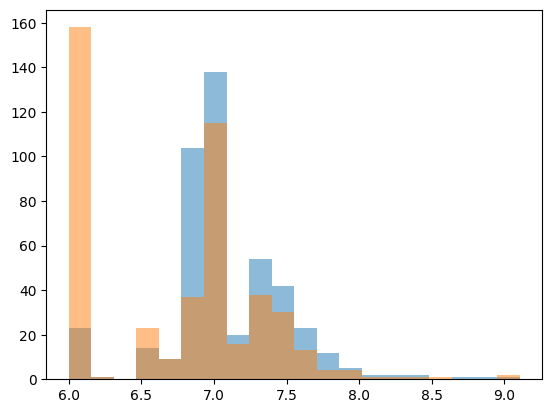

In [95]:
#make plots
#plt.hist(np.log(cigale_df['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5)
plt.hist(np.log10(data_reg_tbl['reg_dolflux_Age_MinChiSq']*1e6), bins=20,alpha=.5, label='Original Age')
plt.hist(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5,label='Age after Av corrected photometry')
plt.hist(np.log10(cigale_df_orig['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5,label='Age with forced Av>1')

plt.title('Age hist of all regions')
plt.legend()
plt.xlabel('age')
#plt.xscale('log')
plt.show()

In [ ]:
print('1My', np.log10(1e6) )
print('3My', np.log10(3e6) )
print('5My', np.log10(5e6) )
print('10My', np.log10(10e6) )


1My 6.0
3My 6.477121254719663
5My 6.698970004336019
10My 7.0


n_corrected 272


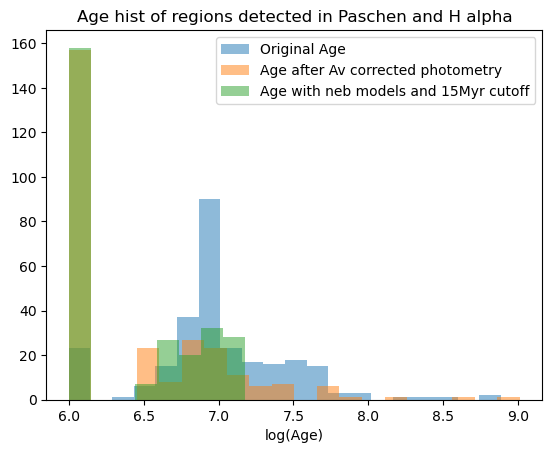

In [ ]:
# age of only corrected regions
fig_dir = 'figures/'
av_corrected = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'] > 0.1)
print('n_corrected',sum(av_corrected))

#plt.hist(np.log(cigale_df['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5)
plt.hist(np.log10(data_reg_tbl['reg_dolflux_Age_MinChiSq'][av_corrected]*1e6), bins=20,alpha=.5, label='Original Age')
plt.hist(np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6), bins= 20,alpha=.5,label='Age after Av corrected photometry')
#plt.hist(np.log10(cigale_df_orig['best.stellar.age_m_star'][av_corrected]*1e6), bins= 20,alpha=.5,label='Age with forced Av>1')
plt.hist(np.log10(cigale_df_neb['best.stellar.age_m_star'][av_corrected]*1e6), bins= 8,alpha=.5,label='Age with neb models and 15Myr cutoff')


plt.title('Age hist of regions detected in Paschen and H alpha')
plt.xlabel('log(Age)')
plt.legend()
#plt.xscale('log')
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Agehist.pdf', bbox_inches='tight', pad_inches=0.15)
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Agehist_Nebular.pdf', bbox_inches='tight', pad_inches=0.15)
plt.show()
plt.close()



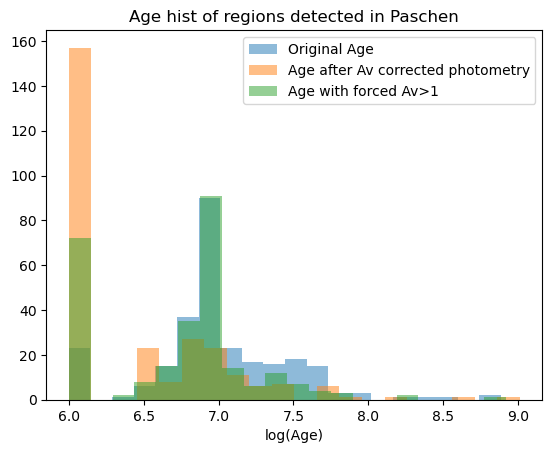

In [ ]:
# age of only corrected regions

av_corrected = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'] > 0.1)

#plt.hist(np.log(cigale_df['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5)
plt.hist(np.log10(data_reg_tbl['reg_dolflux_Age_MinChiSq'][av_corrected]*1e6), bins=20,alpha=.5, label='Original Age')
plt.hist(np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6), bins= 20,alpha=.5,label='Age after Av corrected photometry')
plt.hist(np.log10(cigale_df_orig['best.stellar.age_m_star'][av_corrected]*1e6), bins= 20,alpha=.5,label='Age with forced Av>1')
#plt.hist(np.log10(cigale_df_neb['best.stellar.age_m_star'][av_corrected]*1e6), bins= 8,alpha=.5,label='Age with nebular models and 15Myr cutoff')


plt.title('Age hist of regions detected in Paschen')
plt.xlabel('log(Age)')
plt.legend()
#plt.xscale('log')
plt.show()

In [ ]:
av_corrected_bad = (data_reg_tbl['reg_H_alpha_Luminosity'] > 0.0)
print(np.sum(av_corrected_bad))
av_corrected = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'] > 0.1)
print(np.sum(av_corrected))


425
272


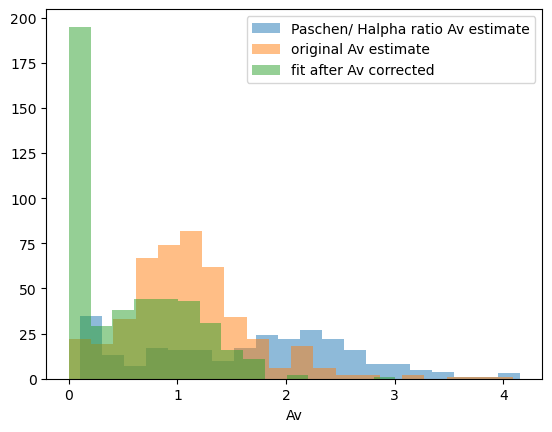

In [ ]:
#make plots
mask_inf = np.isfinite(data_reg_tbl['reg_av_from_ratio'])
mask_Av = ((data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])>0.1)

#plt.hist(np.log(cigale_df['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5)
#plt.hist((data_reg_tbl['reg_ebv_from_ratio'][mask_inf]*3.1), bins=40,alpha=.5,label ='Paschen/ Halpha ratio Av estimate')
plt.hist( ((data_tbl['V_dolmag_vega_old'][mask_Av]-data_tbl['V_dolmag_vega'][mask_Av])) , bins=20,alpha=.5,label ='Paschen/ Halpha ratio Av estimate')

#plt.hist((data_reg_tbl['reg_av_from_ratio']), bins='auto',alpha=.5)
plt.hist((data_reg_tbl['reg_dolflux_Ebv_MinChiSq']*3.1), bins=20,alpha=.5, label = 'original Av estimate')

plt.hist((cigale_df['best.attenuation.A550']), bins= 15,alpha=.5,label='fit after Av corrected')
#plt.hist((cigale_df_orig['best.attenuation.A550']), bins= 10,alpha=.5,label='original with forced Av>1')
plt.legend()
plt.xlabel('Av')
#plt.xscale('log')
plt.show()

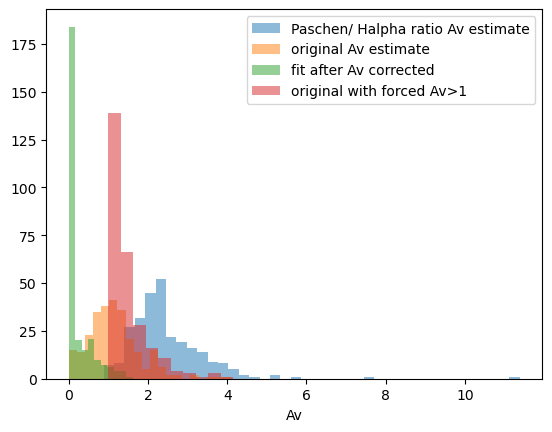

In [ ]:
#make plots
mask_inf = np.isfinite(data_reg_tbl['reg_av_from_ratio'])

#plt.hist(np.log(cigale_df['best.stellar.age_m_star']*1e6), bins= 20,alpha=.5)
plt.hist((data_reg_tbl['reg_ebv_from_ratio'][av_corrected]*3.1), bins=40,alpha=.5,label ='Paschen/ Halpha ratio Av estimate')
#plt.hist((data_reg_tbl['reg_av_from_ratio']), bins='auto',alpha=.5)
plt.hist((data_reg_tbl['reg_dolflux_Ebv_MinChiSq'][av_corrected]*3.1), bins=20,alpha=.5, label = 'original Av estimate')

plt.hist((cigale_df['best.attenuation.A550'][av_corrected]), bins= 10,alpha=.5,label='fit after Av corrected')
plt.hist((cigale_df_orig['best.attenuation.A550'][av_corrected]), bins= 10,alpha=.5,label='original with forced Av>1')
plt.legend()
plt.xlabel('Av')
#plt.xscale('log')
plt.show()

In [ ]:
print(np.mean((data_reg_tbl['reg_dolflux_Age_MinChiSq'])) )
print(np.mean((cigale_df['best.stellar.age_m_star'])) )

print(np.median((data_reg_tbl['reg_dolflux_Age_MinChiSq'])) )
print(np.median((cigale_df['best.stellar.age_m_star'])) )

print(np.log10( np.median(data_reg_tbl['reg_dolflux_Age_MinChiSq']*1e6)) )
print(np.log10( np.median(cigale_df['best.stellar.age_m_star']*1e6)) )

print(np.log10( np.mean(data_reg_tbl['reg_dolflux_Age_MinChiSq']*1e6)) )
print(np.log10( np.mean(cigale_df['best.stellar.age_m_star']*1e6)) )


23.997797356828194
17.63215859030837
10.0
8.0
7.0
6.903089986991944
7.38017138172517
7.246305483398214


451
4.799765969846229


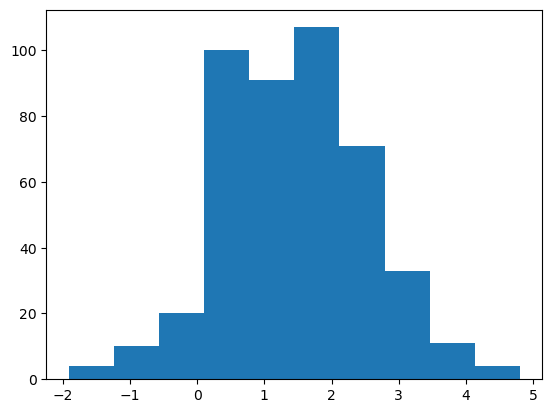

In [ ]:
mask_inf = np.isfinite(data_reg_tbl['reg_ratio_H_alpha_to_Pa_alpha'])
print(np.sum(mask_inf))
print(np.max(data_reg_tbl['reg_ratio_H_alpha_to_Pa_alpha'][mask_inf]) )
plt.hist( data_reg_tbl['reg_ratio_H_alpha_to_Pa_alpha'][mask_inf] )
plt.show()

Text(0.5, 0, 'log(Age)[yr]')

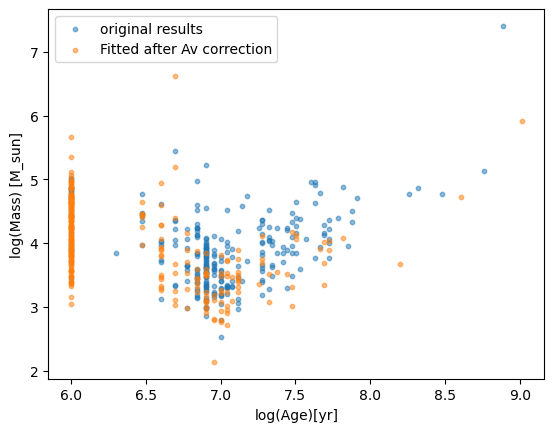

In [ ]:
#------------------------------------
# Age vs Mass
plt.scatter(np.log10(data_reg_tbl['reg_dolflux_Age_MinChiSq'][av_corrected]*1e6),np.log10(data_reg_tbl['reg_dolflux_Mass_MinChiSq'][av_corrected]),s=10,alpha=0.5,label='original results')

plt.scatter(np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6),np.log10(cigale_df['best.stellar.m_star'][av_corrected]),s=10,alpha=0.5,label='Fitted after Av correction')

#plt.title(gal+' ws level: '+pc_scales[i])
plt.legend()
plt.ylabel('log(Mass) [M_sun]')
plt.xlabel('log(Age)[yr]')

In [96]:
print(np.log10(1e6),np.log10(3e6),np.log10(5e6),np.log10(7e6),np.log10(10e6),np.log10(30e6),np.log10(50e6),np.log10(100e6),np.log10(200e6),np.log10(300e6),np.log10(500e6),np.log10(1000e6))


6.0 6.477121254719663 6.698970004336019 6.845098040014257 7.0 7.477121254719663 7.698970004336019 8.0 8.301029995663981 8.477121254719663 8.698970004336019 9.0


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

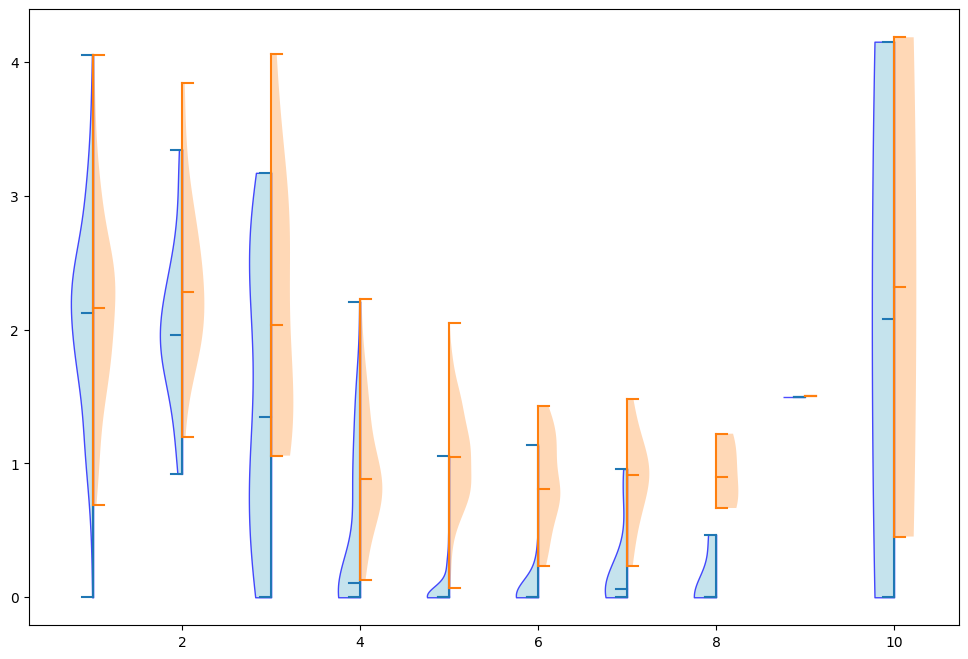

In [142]:
# Create bins for age
#age_bins =   [6.0,  6.47,   6.69,    6.845,     7.0,      7.477,      7.69,     7.85,         8.0,        8.477,        8.69,         9.5]
#age_labels = ['1-3Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr','30-50Myr','50-70Myr', '70-100Myr', '100-300Myr', '300-500Myr', '>500 Myr']
# Create bins for age
age_bins =   [6.0,  6.47,   6.69,    6.845,     7.0,      7.477,      7.69,         8.0,        8.477,        8.69,         9.5]
age_labels = ['1-3Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr','30-50Myr','50-100Myr', '100-300Myr', '300-500Myr', '>500 Myr']
v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) +cigale_df['bayes.attenuation.A550']
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])


#age_labels = ['1Myr', '3 Myr', '5 Myr','7 Myr', '10 Myr', '30 Myr', '50 Myr', '100 Myr', '200 Myr', '300 Myr', '500 Myr','1 Gyr']
#n_bins = 12

# Bin the stellar age data
cigale_df['age_bin'] = pd.cut(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins=age_bins, labels=age_labels, right=False)

# Create a list of Av values for each age bin
av_data_by_age_bin = [v_diff[cigale_df['age_bin'] == label] for label in age_labels]
av_tot_data_by_age_bin = [v_diff_all[cigale_df['age_bin'] == label] for label in age_labels]


# Create the violin plot
plt.figure(figsize=(12, 8))
violin_parts = plt.violinplot(av_data_by_age_bin, showmedians=True, side='low') #, label='Av from decrement'
plt.violinplot(av_tot_data_by_age_bin, showmedians=True, side='high') #label='Total Av (decrement + SED-fit extinction)'

# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# adding quartile boxes
quartile1, medians, quartile3 = np.percentile(av_tot_data_by_age_bin, [25, 50, 75], axis=1)
whiskers = np.array([
    adjacent_values(sorted_array, q1, q3)
    for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
whiskers_min, whiskers_max = whiskers[:, 0], whiskers[:, 1]

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

#----

inds = np.arange(1, len(medians) + 1)
ax2.scatter(inds, medians, marker='o', color='white', s=30, zorder=3)
ax2.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=5)
ax2.vlines(inds, whiskers_min, whiskers_max, color='k', linestyle='-', lw=1)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks(np.arange(1, len(age_labels) + 1), age_labels)
plt.ylabel('Av')
plt.xlabel('Stellar Age Bin')
plt.title('Violin Plot of Av by Stellar Age Bin')
plt.grid(True)
plt.show()

In [155]:
quartile1, medians, quartile3 = np.percentile(av_tot_data_by_age_bin, [25, 50, 75], axis=0)
#av_tot_data_by_age_bin[1]

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (10,) + inhomogeneous part.

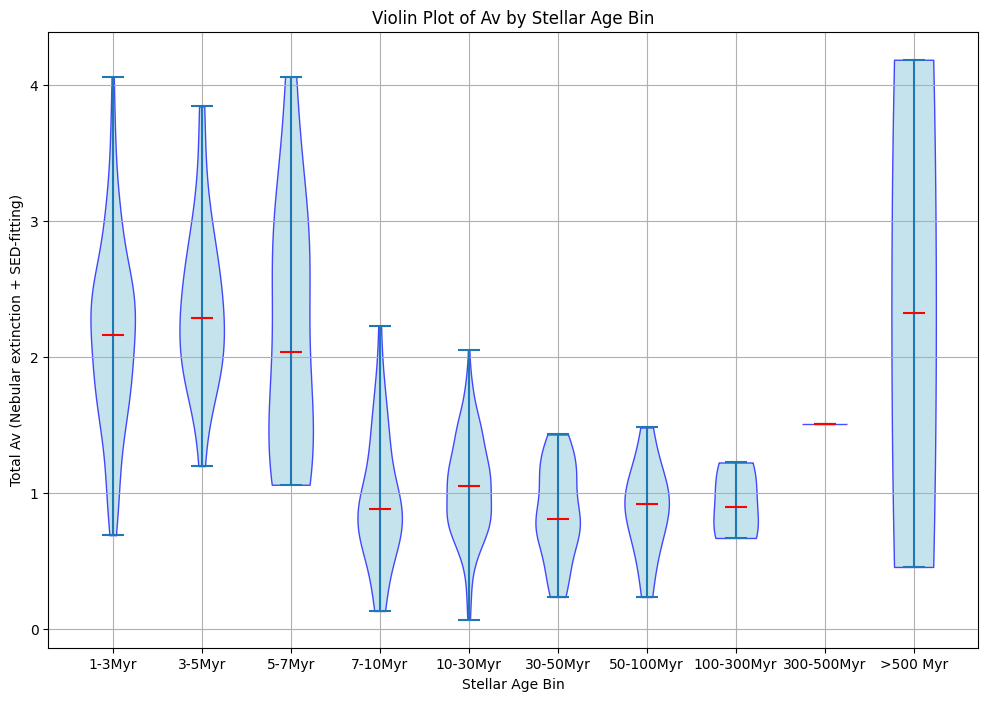

In [132]:
# Create bins for age
#age_bins =   [6.0,  6.47,   6.69,    6.845,     7.0,      7.477,      7.69,     7.85,         8.0,        8.477,        8.69,         9.5]
#age_labels = ['1-3Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr','30-50Myr','50-70Myr', '70-100Myr', '100-300Myr', '300-500Myr', '>500 Myr']
# Create bins for age
age_bins =   [6.0,  6.47,   6.69,    6.845,     7.0,      7.477,      7.69,         8.0,        8.477,        8.69,         9.5]
age_labels = ['1-3Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr','30-50Myr','50-100Myr', '100-300Myr', '300-500Myr', '>500 Myr']

v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) +cigale_df['bayes.attenuation.A550']
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])


#age_labels = ['1Myr', '3 Myr', '5 Myr','7 Myr', '10 Myr', '30 Myr', '50 Myr', '100 Myr', '200 Myr', '300 Myr', '500 Myr','1 Gyr']
#n_bins = 12

# Bin the stellar age data
cigale_df['age_bin'] = pd.cut(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins=age_bins, labels=age_labels, right=False)

# Create a list of Av values for each age bin
av_data_by_age_bin = [v_diff[cigale_df['age_bin'] == label] for label in age_labels]
av_tot_data_by_age_bin = [v_diff_all[cigale_df['age_bin'] == label] for label in age_labels]


# Create the violin plot
plt.figure(figsize=(12, 8))
violin_parts = plt.violinplot(av_tot_data_by_age_bin, showmedians=True)
#plt.violinplot(av_tot_data_by_age_bin, showmedians=True)

# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks(np.arange(1, len(age_labels) + 1), age_labels)
plt.ylabel('Total Av (Nebular extinction + SED-fitting)')
plt.xlabel('Stellar Age Bin')
plt.title('Violin Plot of Av by Stellar Age Bin')
plt.grid(True)
plt.show()

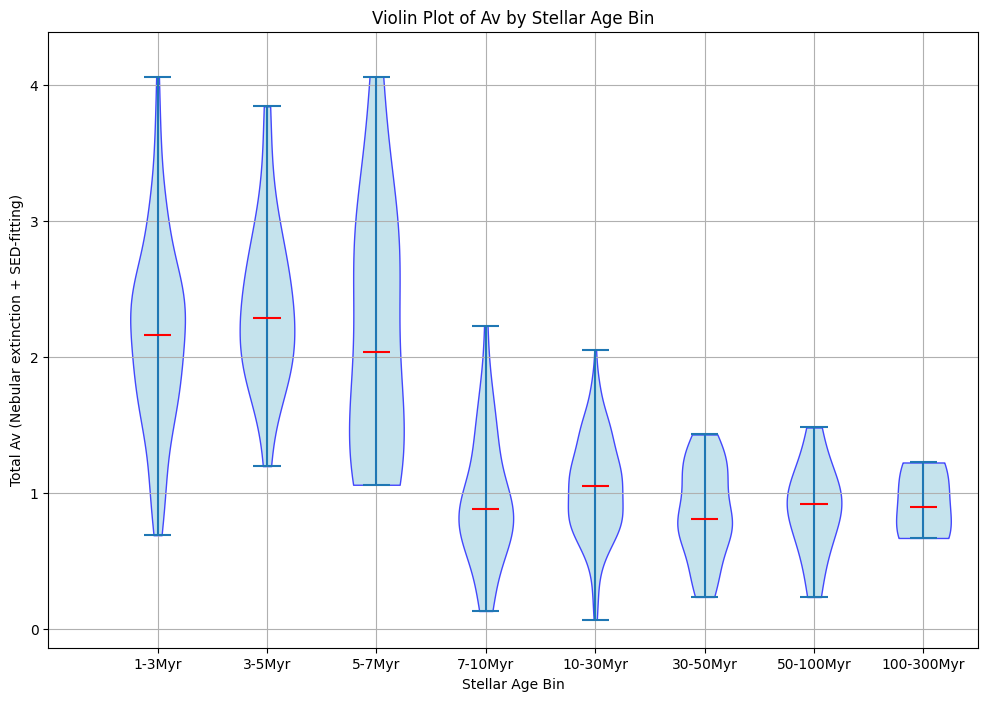

In [136]:
#Cut x-range to remove large ages/low statistic bins

# Create bins for age
#age_bins =   [6.0,  6.47,   6.69,    6.845,     7.0,      7.477,      7.69,     7.85,         8.0,        8.477,        8.69,         9.5]
#age_labels = ['1-3Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr','30-50Myr','50-70Myr', '70-100Myr', '100-300Myr', '300-500Myr', '>500 Myr']
# Create bins for age
age_bins =   [6.0,  6.47,   6.69,    6.845,     7.0,      7.477,      7.69,         8.0,        8.477,        8.69,         9.5]
age_labels = ['1-3Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr','30-50Myr','50-100Myr', '100-300Myr', '300-500Myr', '>500 Myr']

v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) +cigale_df['bayes.attenuation.A550']
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])


#age_labels = ['1Myr', '3 Myr', '5 Myr','7 Myr', '10 Myr', '30 Myr', '50 Myr', '100 Myr', '200 Myr', '300 Myr', '500 Myr','1 Gyr']
#n_bins = 12

# Bin the stellar age data
cigale_df['age_bin'] = pd.cut(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins=age_bins, labels=age_labels, right=False)

# Create a list of Av values for each age bin
av_data_by_age_bin = [v_diff[cigale_df['age_bin'] == label] for label in age_labels]
av_tot_data_by_age_bin = [v_diff_all[cigale_df['age_bin'] == label] for label in age_labels]


# Create the violin plot
plt.figure(figsize=(12, 8))
violin_parts = plt.violinplot(av_tot_data_by_age_bin, showmedians=True)
#plt.violinplot(av_tot_data_by_age_bin, showmedians=True)

# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks(np.arange(1, len(age_labels) + 1), age_labels)
plt.ylabel('Total Av (Nebular extinction + SED-fitting)')
plt.xlim(0,8.5)
plt.xlabel('Stellar Age Bin')
plt.title('Violin Plot of Av by Stellar Age Bin')
plt.grid(True)
plt.show()

[6.         6.28235006 6.56470012 6.84705018 7.12940025 7.41175031
 7.69410037 7.97645043 8.25880049 8.54115055 8.82350061 9.10895653]
[1.00000000e+06 1.91579953e+06 3.67028782e+06 7.03153567e+06
 1.34710127e+07 2.58077597e+07 4.94424938e+07 9.47219062e+07
 1.81468183e+08 3.47656659e+08 6.66040462e+08 1.28515800e+09]


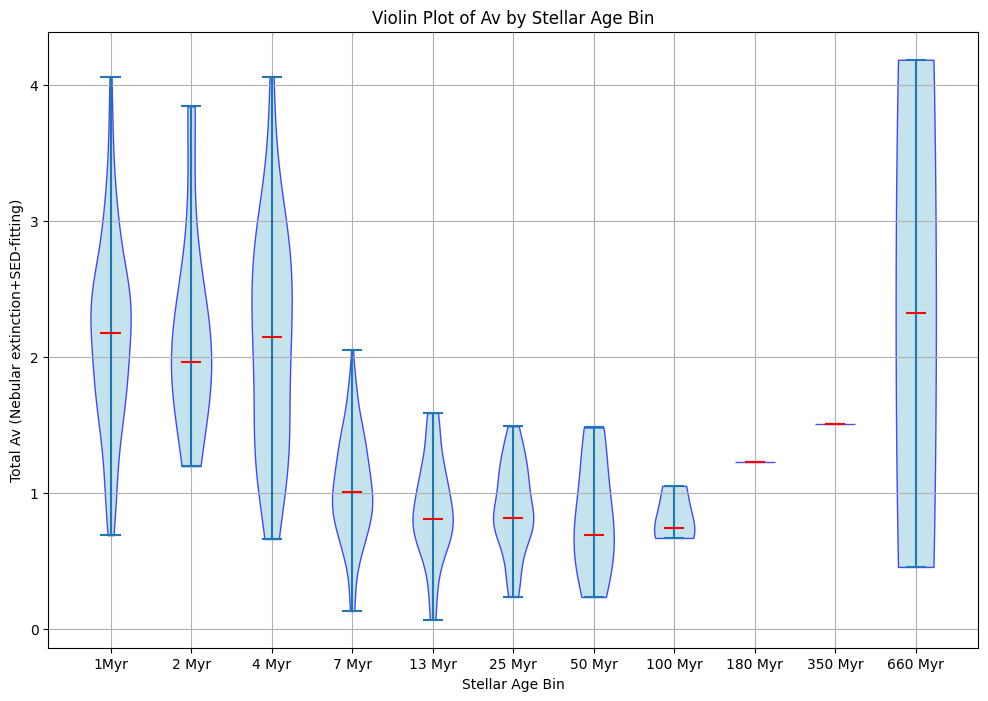

In [129]:
# Create bins for age
#age_bins = [6.0, 6.47, 6.699, 6.5,7.0, 7.477, 9.5] # 1Myr, 3Myr, 5Myr, 10Myr, 30Myr, max_age
#age_labels = ['<1Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr', '>30Myr']
v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) +cigale_df['bayes.attenuation.A550']
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])


#age_labels = ['1Myr', '3 Myr', '5 Myr','7 Myr', '10 Myr', '30 Myr', '50 Myr', '100 Myr', '200 Myr', '300 Myr', '500 Myr']#,'1 Gyr']
age_labels = ['1Myr', '2 Myr', '4 Myr','7 Myr', '13 Myr', '25 Myr', '50 Myr', '100 Myr', '180 Myr', '350 Myr', '660 Myr']#,'1 Gyr']

n_bins = 11

# Bin the stellar age data
cigale_df['age_bin'],age_bins_ret = pd.cut(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins=n_bins, retbins=True, labels=age_labels, right=False)

print(age_bins_ret)
print( 10**(age_bins_ret) )
# Create a list of Av values for each age bin
av_data_by_age_bin = [v_diff[cigale_df['age_bin'] == label] for label in age_labels]
av_tot_data_by_age_bin = [v_diff_all[cigale_df['age_bin'] == label] for label in age_labels]


# Create the violin plot
plt.figure(figsize=(12, 8))
violin_parts = plt.violinplot(av_tot_data_by_age_bin, showmedians=True)


# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks(np.arange(1, len(age_labels) + 1), age_labels)
plt.ylabel('Total Av (Nebular extinction+SED-fitting)')
plt.xlabel('Stellar Age Bin')
plt.title('Violin Plot of Av by Stellar Age Bin')
plt.grid(True)

#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_AgeBin_TotalAv_Violin.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

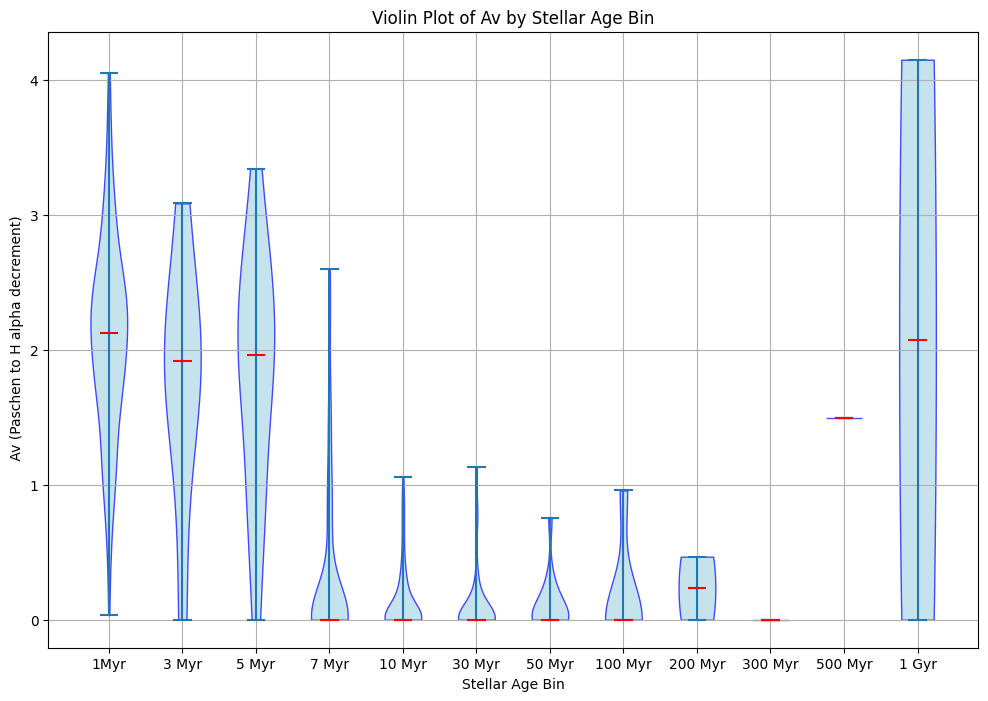

In [59]:
# Create bins for age
#age_bins = [6.0, 6.47, 6.699, 6.5,7.0, 7.477, 9.5] # 1Myr, 3Myr, 5Myr, 10Myr, 30Myr, max_age
#age_labels = ['<1Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr', '>30Myr']

v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) +cigale_df['bayes.attenuation.A550']
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])


age_labels = ['1Myr', '3 Myr', '5 Myr','7 Myr', '10 Myr', '30 Myr', '50 Myr', '100 Myr', '200 Myr', '300 Myr', '500 Myr','1 Gyr']

n_bins = 12

# Bin the stellar age data
cigale_df['age_bin'] = pd.cut(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins=n_bins, labels=age_labels, right=False)

# Create a list of Av values for each age bin
av_data_by_age_bin = [v_diff[cigale_df['age_bin'] == label] for label in age_labels]
av_tot_data_by_age_bin = [v_diff_all[cigale_df['age_bin'] == label] for label in age_labels]


# Create the violin plot
plt.figure(figsize=(12, 8))
violin_parts = plt.violinplot(av_data_by_age_bin, showmedians=True)


# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks(np.arange(1, len(age_labels) + 1), age_labels)
plt.ylabel(' Av (Paschen to H alpha decrement)')
plt.xlabel('Stellar Age Bin')
plt.title('Violin Plot of Av by Stellar Age Bin')
plt.grid(True)
plt.show()

## Make CC diagrams


In [26]:
## Make CC diagrams

Myr = (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 6.2)
print(sum(Myr))

av_corrected = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'] > 0.1)
print(np.sum(av_corrected))

not_corrected = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'] < 0.1)
print(np.sum(not_corrected))



NameError: name 'av_corrected' is not defined

In [ ]:
Myr = (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 6.4)
print(sum(Myr))
Myr3_5 = ((np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) > 6.4) & (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 6.7) )
print(sum(Myr3_5))
Myr5_10 = ((np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) > 6.7) & (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 7.0) )
print(sum(Myr5_10))

Myr10_30 = ((np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) > 7.0)  & (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 7.477) )
print(sum(Myr10))


In [27]:
print(np.log10(5e6))

6.698970004336019


In [28]:
# Calculate color indices


v_i_color = data_tbl['V_dolmag_vega_old'][av_corrected] - data_tbl['I_dolmag_vega_old'][av_corrected]
u_b_color = data_tbl['U_dolmag_vega_old'][av_corrected] - data_tbl['B_dolmag_vega_old'][av_corrected]

v_i_color_new = data_tbl['V_dolmag_vega'][av_corrected] - data_tbl['I_dolmag_vega'][av_corrected]
u_b_color_new = data_tbl['U_dolmag_vega'][av_corrected] - data_tbl['B_dolmag_vega'][av_corrected]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color[Myr],u_b_color[Myr], s=10, alpha=0.5,color='orange',label = 'original')
plt.scatter(v_i_color_new[Myr],u_b_color_new[Myr],color='blue', s=50,marker='*', alpha=0.35,label = '1 to 3Myr after Av corrected photometry')
#plt.scatter(v_i_color[Myr],u_b_color[Myr], s=10, alpha=0.5,color='blue',label = '1Myr after correction')

plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
#plt.ylim(0.5,-3)
plt.ylim(0.5,-2.5)
plt.xlim(-1.5,2.0)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt. legend()
plt.title('Color-Color Plot')
plt.grid(True)

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_CC_1_3Mry.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

NameError: name 'av_corrected' is not defined

In [ ]:
#Myr = (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 6.2)
#print(sum(Myr))
#3-5Myr

v_i_color = data_tbl['V_dolmag_vega_old'][av_corrected] - data_tbl['I_dolmag_vega_old'][av_corrected]
u_b_color = data_tbl['U_dolmag_vega_old'][av_corrected] - data_tbl['B_dolmag_vega_old'][av_corrected]

v_i_color_new = data_tbl['V_dolmag_vega'][av_corrected] - data_tbl['I_dolmag_vega'][av_corrected]
u_b_color_new = data_tbl['U_dolmag_vega'][av_corrected] - data_tbl['B_dolmag_vega'][av_corrected]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color[Myr3_5],u_b_color[Myr3_5], s=15, alpha=0.75,color='orange',label = 'Original')
#plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5,color='green',label = 'After Av corrected photometry')

plt.scatter(v_i_color_new[Myr3_5],u_b_color_new[Myr3_5],color='purple', s=50,marker='*', alpha=0.7,label = '3-5 Myr after Av corrected photometry')
#plt.scatter(v_i_color[Myr],u_b_color[Myr], s=10, alpha=0.5,color='blue',label = '1Myr after correction')

plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-2.5)
plt.xlim(-1.5,2.0)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt. legend()
plt.title('Color-Color Plot')
plt.grid(True)

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_CC_3_5Mry.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

In [ ]:
Myr = (np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6) < 6.2)
print(sum(Myr))

v_i_color = data_tbl['V_dolmag_vega_old'][av_corrected] - data_tbl['I_dolmag_vega_old'][av_corrected]
u_b_color = data_tbl['U_dolmag_vega_old'][av_corrected] - data_tbl['B_dolmag_vega_old'][av_corrected]

v_i_color_new = data_tbl['V_dolmag_vega'][av_corrected] - data_tbl['I_dolmag_vega'][av_corrected]
u_b_color_new = data_tbl['U_dolmag_vega'][av_corrected] - data_tbl['B_dolmag_vega'][av_corrected]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color,u_b_color, s=10, alpha=0.5,color='orange',label = 'Original')
plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5,color='green',label = 'After Av corrected photometry')

plt.scatter(v_i_color_new[Myr],u_b_color_new[Myr],color='blue', s=50,marker='*', alpha=0.35,label = '1Myr after Av corrected photometry')
#plt.scatter(v_i_color[Myr],u_b_color[Myr], s=10, alpha=0.5,color='blue',label = '1Myr after correction')

plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-3)
plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt. legend()
plt.title('Color-Color Plot')
plt.grid(True)

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_CC_1Mry.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

In [ ]:
v_i_color = data_tbl['V_dolmag_vega_old'][av_corrected] - data_tbl['I_dolmag_vega_old'][av_corrected]
u_b_color = data_tbl['U_dolmag_vega_old'][av_corrected] - data_tbl['B_dolmag_vega_old'][av_corrected]

v_i_color_new = data_tbl['V_dolmag_vega'][av_corrected] - data_tbl['I_dolmag_vega'][av_corrected]
u_b_color_new = data_tbl['U_dolmag_vega'][av_corrected] - data_tbl['B_dolmag_vega'][av_corrected]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(v_i_color[Myr5_10],u_b_color[Myr5_10], s=15, alpha=0.75,color='orange',label = 'Original')
#plt.scatter(v_i_color_new,u_b_color_new, s=10, alpha=0.5,color='green',label = 'After Av corrected photometry')

plt.scatter(v_i_color_new[Myr5_10],u_b_color_new[Myr5_10],color='green', s=50,marker='*', alpha=0.75,label = '5-10 Myr after Av corrected photometry')
#plt.scatter(v_i_color[Myr],u_b_color[Myr], s=10, alpha=0.5,color='blue',label = '1Myr after correction')

plt.plot(bc03_V_vega-bc03_I_vega,bc03_U_vega-bc03_B_vega,linewidth=2 )
plt.ylim(0.5,-2.5)
plt.xlim(-1.5,2.0)

plt.ylabel('U_dolmag_vega - B_dolmag_vega')
plt.xlabel('V_dolmag_vega - I_dolmag_vega')
plt. legend()
plt.title('Color-Color Plot')
plt.grid(True)

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_CC_5_10Mry.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

## Figures with Covering fraction


In [102]:
# read in Covering Fraction data
covFrac_file = 'reg_ha_paa_pah7p7_ebv_nii0p8_20250509_gini_covfrac'

covFrac_tbl = Table.read(data_dir+covFrac_file+'.fits', format='fits')
covFrac_df = covFrac_tbl.to_pandas()

av_corrected = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'] > 0.1)
print(np.sum(av_corrected))

272


In [103]:
covFrac_df.columns

Index(['reg_id', 'reg_x', 'reg_y', 'reg_ra', 'reg_dec', 'reg_area', 'reg_rad',
       'NUV_dolflux_mjy', 'NUV_dolflux_mjy_err', 'U_dolflux_mjy',
       'U_dolflux_mjy_err', 'B_dolflux_mjy', 'B_dolflux_mjy_err',
       'V_dolflux_mjy', 'V_dolflux_mjy_err', 'I_dolflux_mjy',
       'I_dolflux_mjy_err', 'NUV_dolmag_vega', 'NUV_dolmag_vega_err',
       'U_dolmag_vega', 'U_dolmag_vega_err', 'B_dolmag_vega',
       'B_dolmag_vega_err', 'V_dolmag_vega', 'V_dolmag_vega_err',
       'I_dolmag_vega', 'I_dolmag_vega_err', 'reg_dolflux_Age_MinChiSq',
       'reg_dolflux_Age_MinChiSq_err', 'reg_dolflux_Mass_MinChiSq',
       'reg_dolflux_Mass_MinChiSq_err', 'reg_dolflux_Ebv_MinChiSq',
       'reg_dolflux_Ebv_MinChiSq_err', 'reg_dolflux_ChiSq_Reduced',
       'reg_n_pixel', 'reg_H_alpha_Luminosity',
       'reg_H_alpha_Luminosity_local_sub', 'reg_H_alpha_std',
       'reg_H_alpha_annulus_mean', 'reg_H_alpha_annulus_median',
       'reg_H_alpha_annulus_std', 'reg_H_alpha_annulus_n_pixel',
       'reg_

/tmp/ipython-input-32374477.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


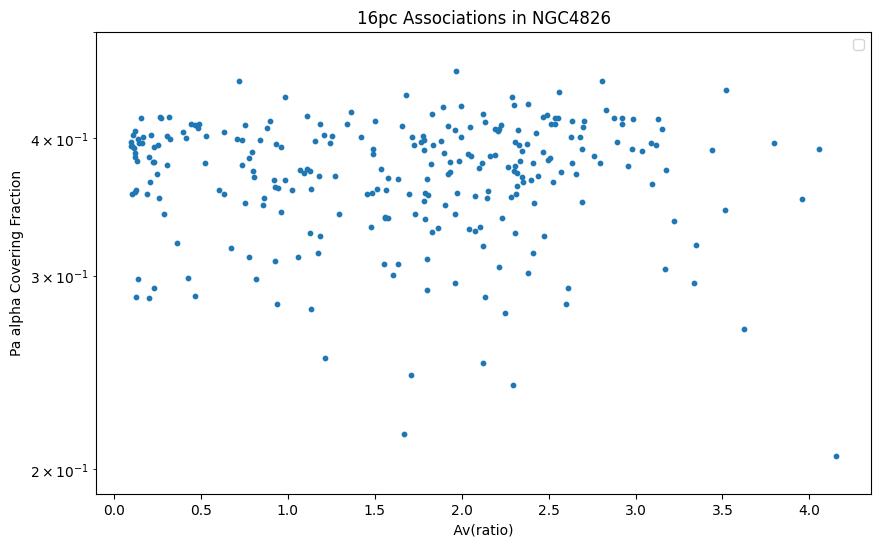

In [113]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])
v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) + cigale_tbl['best.attenuation.A550']

plt.scatter( v_diff[av_corrected],covFrac_df['reg_Pa_alpha_CDF_Covering_Fraction'][av_corrected], s=10)
#plt.scatter( v_diff,covFrac_df['reg_PAH7p7_Luminosity'], s=10,color='orange',alpha=0.5)
#plt.scatter( v_diff[av_corrected],covFrac_df['reg_PAH7p7_Luminosity'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('Pa alpha Covering Fraction')
plt.xlabel(' Av(ratio) ')

plt.ylim(.19,.5)
plt.yscale('log')
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

/tmp/ipython-input-3936014344.py:19: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


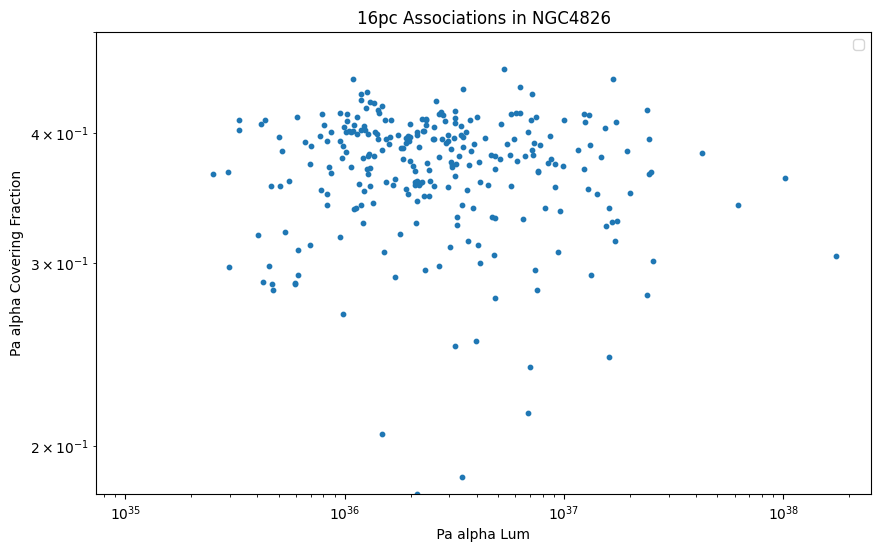

In [118]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega'])
v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) + cigale_tbl['best.attenuation.A550']

plt.scatter( covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected],covFrac_df['reg_Pa_alpha_CDF_Covering_Fraction'][av_corrected], s=10)
#plt.scatter( v_diff,covFrac_df['reg_PAH7p7_Luminosity'], s=10,color='orange',alpha=0.5)
#plt.scatter( v_diff[av_corrected],covFrac_df['reg_PAH7p7_Luminosity'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('Pa alpha Covering Fraction')
plt.xlabel(' Pa alpha Lum ')

plt.ylim(.18,.5)
plt.yscale('log')
plt.xscale('log')
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

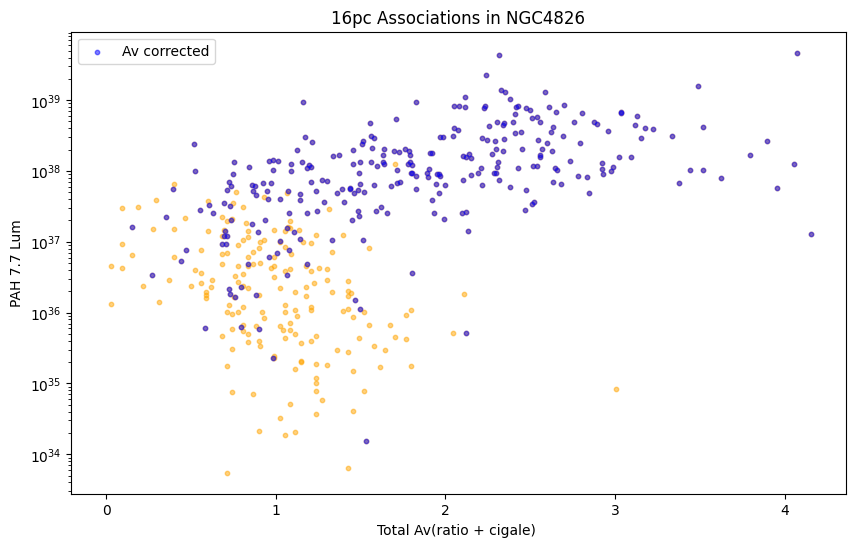

In [18]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) + cigale_tbl['best.attenuation.A550']
#plt.scatter( association_age,covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected], s=10)
plt.scatter( v_diff,covFrac_df['reg_PAH7p7_Luminosity'], s=10,color='orange',alpha=0.5)
plt.scatter( v_diff[av_corrected],covFrac_df['reg_PAH7p7_Luminosity'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('PAH 7.7 Lum')
plt.xlabel('Total Av(ratio + cigale) ')

plt.yscale('log')
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

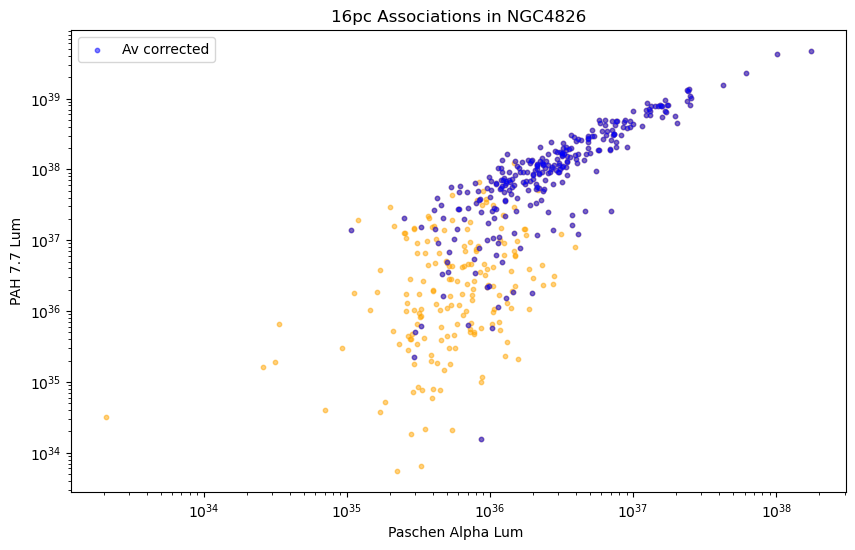

In [ ]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
#plt.scatter( association_age,covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected], s=10)


plt.scatter( covFrac_df['reg_Pa_alpha_Luminosity'],covFrac_df['reg_PAH7p7_Luminosity'], s=10,color='orange',alpha=0.5)
plt.scatter( covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected],covFrac_df['reg_PAH7p7_Luminosity'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')
#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('PAH 7.7 Lum')
#plt.xlabel('Association Log(Age [yr]) ')
plt.xlabel('Paschen Alpha Lum ')

plt.yscale('log')
plt.xscale('log')

plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

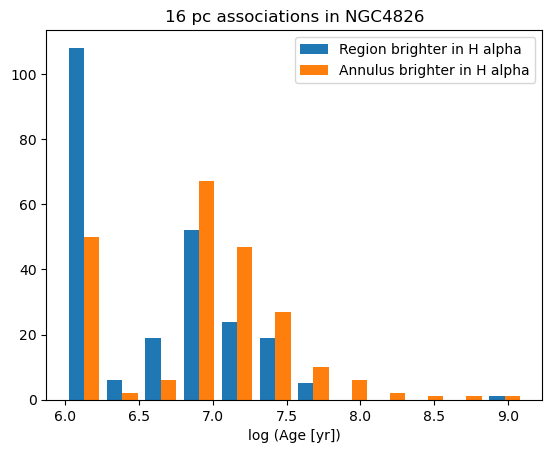

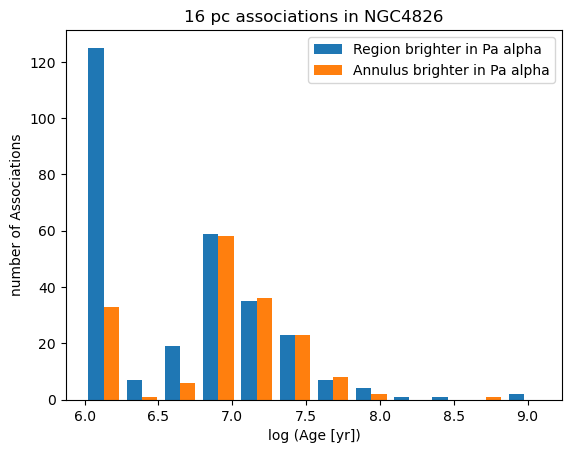

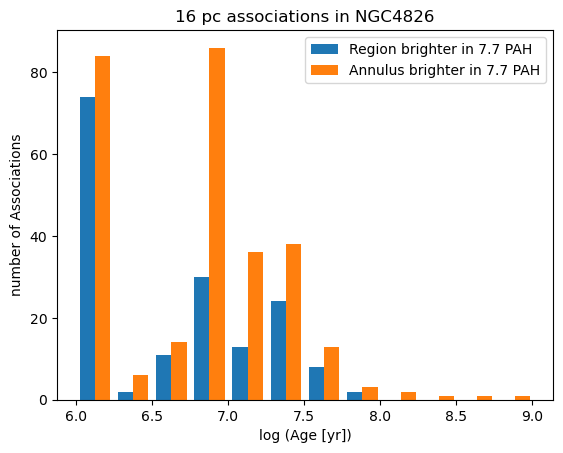

In [ ]:
#-----
#fraction of positive to neg. regions
Ha_Lum_local_sub_pos = (covFrac_df['reg_H_alpha_Luminosity_local_sub'] > 0.0)
Ha_Lum_local_sub_neg = (covFrac_df['reg_H_alpha_Luminosity_local_sub'] < 0.0)
hist_label = ['Region brighter in H alpha','Annulus brighter in H alpha']
n_bins = 12
plt.hist( [ association_age[Ha_Lum_local_sub_pos] , association_age[Ha_Lum_local_sub_neg]], n_bins, label=hist_label) #,stacked=True
plt.legend()
plt.title('16 pc associations in NGC4826')
plt.xlabel('log (Age [yr])')

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_nBright_Ha_hist.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()
#----
#-----
#fraction of positive to neg. regions
Pa_Lum_local_sub_pos = (covFrac_df['reg_Pa_alpha_Luminosity_local_sub'] > 0.0)
Pa_Lum_local_sub_neg = (covFrac_df['reg_Pa_alpha_Luminosity_local_sub'] < 0.0)
hist_label = ['Region brighter in Pa alpha','Annulus brighter in Pa alpha']
n_bins = 12
plt.hist( [ association_age[Pa_Lum_local_sub_pos] , association_age[Pa_Lum_local_sub_neg]], n_bins, label=hist_label) #,stacked=True
plt.legend()
plt.title('16 pc associations in NGC4826')
plt.ylabel('number of Associations')
plt.xlabel('log (Age [yr])')

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_nBright_Pa_hist.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()
#----

#fraction of positive to neg. regions
PAH_7p7Lum_local_sub_pos = (covFrac_df['reg_PAH7p7_Luminosity_local_sub'] > 0.0)
PAH_7p7Lum_local_sub_neg = (covFrac_df['reg_PAH7p7_Luminosity_local_sub'] < 0.0)
hist_label = ['Region brighter in 7.7 PAH','Annulus brighter in 7.7 PAH']
n_bins = 12
plt.hist( [ association_age[PAH_7p7Lum_local_sub_pos] , association_age[PAH_7p7Lum_local_sub_neg]], n_bins, label=hist_label) #,stacked=True
plt.legend()
plt.title('16 pc associations in NGC4826')
plt.ylabel('number of Associations')
plt.xlabel('log (Age [yr])')

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_nBright_PAH_hist.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

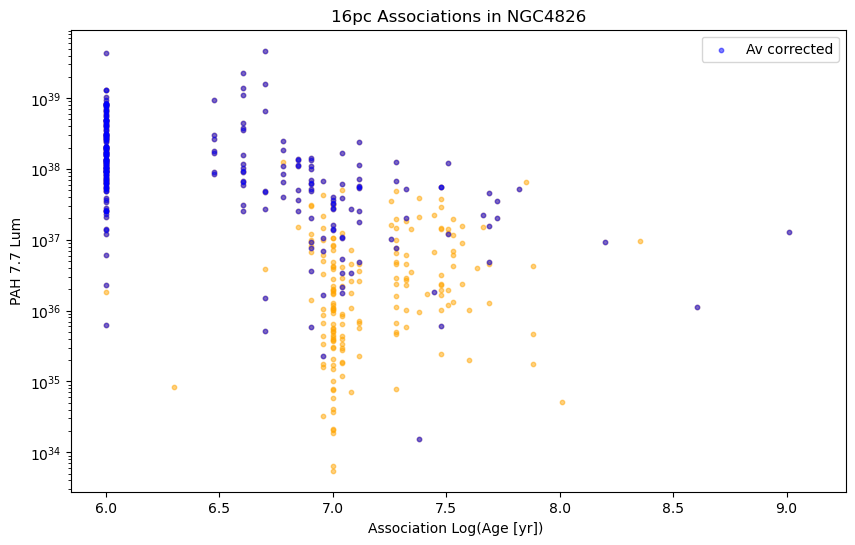

In [ ]:
# 7.7 PAH lum

plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
#plt.scatter( association_age,covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected], s=10)
plt.scatter( association_age,covFrac_df['reg_PAH7p7_Luminosity'], s=10,color='orange',alpha=0.5)
plt.scatter( association_age[av_corrected],covFrac_df['reg_PAH7p7_Luminosity'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('PAH 7.7 Lum')
plt.xlabel('Association Log(Age [yr]) ')
plt.yscale('log')
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

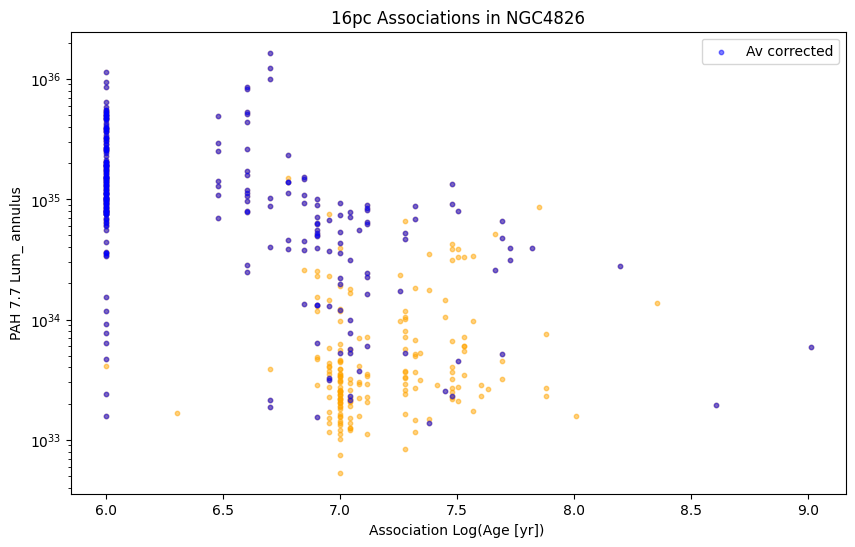

In [31]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
#plt.scatter( association_age,covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected], s=10)
plt.scatter( association_age,covFrac_df['reg_PAH7p7_annulus_median'], s=10,color='orange',alpha=0.5)
plt.scatter( association_age[av_corrected],covFrac_df['reg_PAH7p7_annulus_median'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('PAH 7.7 Lum_ annulus')
plt.xlabel('Association Log(Age [yr]) ')
plt.yscale('log')
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum_annulus.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

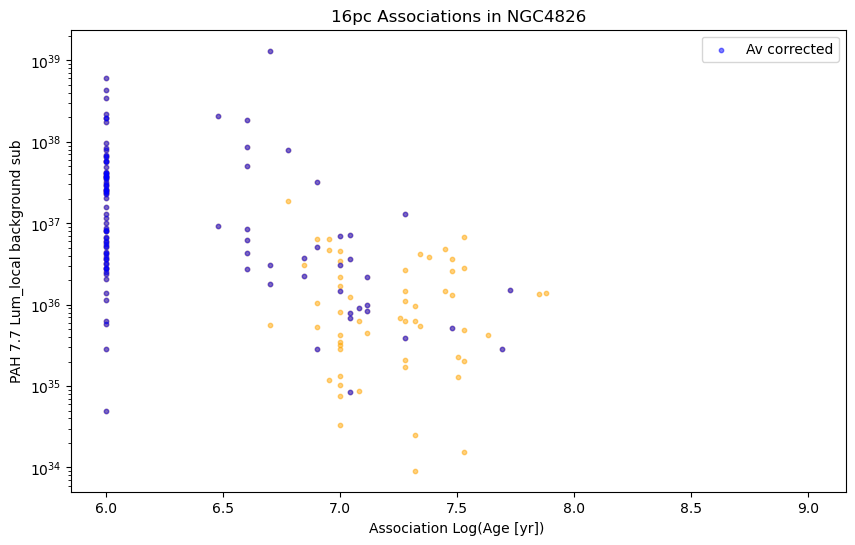

-3.596405488030586e+38


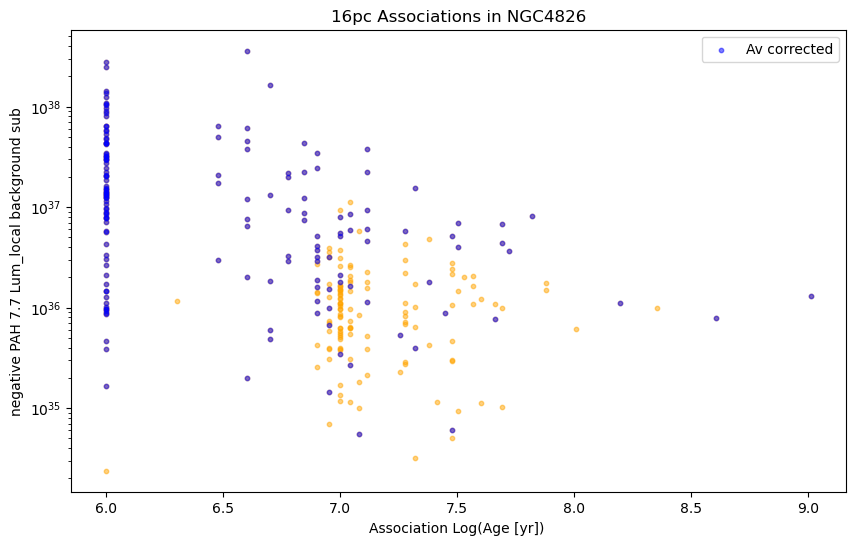

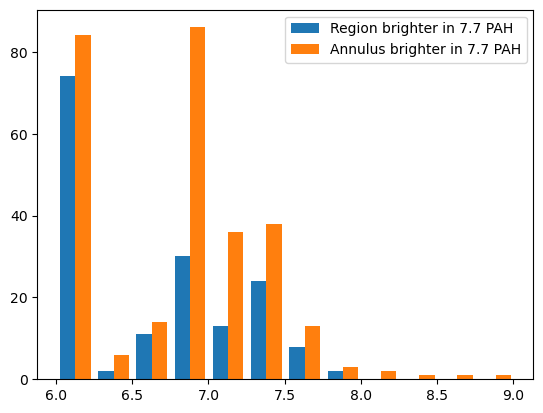

In [ ]:
# 7.7 PAH lum

plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
#plt.scatter( association_age,covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected], s=10)
plt.scatter( association_age,covFrac_df['reg_PAH7p7_Luminosity_local_sub'], s=10,color='orange',alpha=0.5)
plt.scatter( association_age[av_corrected],covFrac_df['reg_PAH7p7_Luminosity_local_sub'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('PAH 7.7 Lum_local background sub')
plt.xlabel('Association Log(Age [yr]) ')
plt.yscale('log')
#plt.ylim(-1e34,-1e38)
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)
plt.show()

#--------_-----------
print(np.min(covFrac_df['reg_PAH7p7_Luminosity_local_sub']))
#-----------------------
plt.figure(figsize=(10, 6))
#plt.scatter( association_age,covFrac_df['reg_Pa_alpha_Luminosity'][av_corrected], s=10)
plt.scatter( association_age,-covFrac_df['reg_PAH7p7_Luminosity_local_sub'], s=10,color='orange',alpha=0.5)
plt.scatter( association_age[av_corrected],-covFrac_df['reg_PAH7p7_Luminosity_local_sub'][av_corrected], s=10 ,color='blue',alpha=0.5, label='Av corrected')

#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16pc Associations in NGC4826')
plt.ylabel('negative PAH 7.7 Lum_local background sub')
plt.xlabel('Association Log(Age [yr]) ')
plt.yscale('log')
#plt.ylim(-1e34,-1e38)
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_PAHlum.pdf', bbox_inches='tight', pad_inches=0.15)
plt.show()

#-----
#fraction of positive to neg. regions
PAH_7p7Lum_local_sub_pos = (covFrac_df['reg_PAH7p7_Luminosity_local_sub'] > 0.0)
PAH_7p7Lum_local_sub_neg = (covFrac_df['reg_PAH7p7_Luminosity_local_sub'] < 0.0)
hist_label = ['Region brighter in 7.7 PAH','Annulus brighter in 7.7 PAH']
n_bins = 12
plt.hist( [ association_age[PAH_7p7Lum_local_sub_pos] , association_age[PAH_7p7Lum_local_sub_neg]], n_bins, label=hist_label) #,stacked=True
plt.legend()
plt.show()
#----


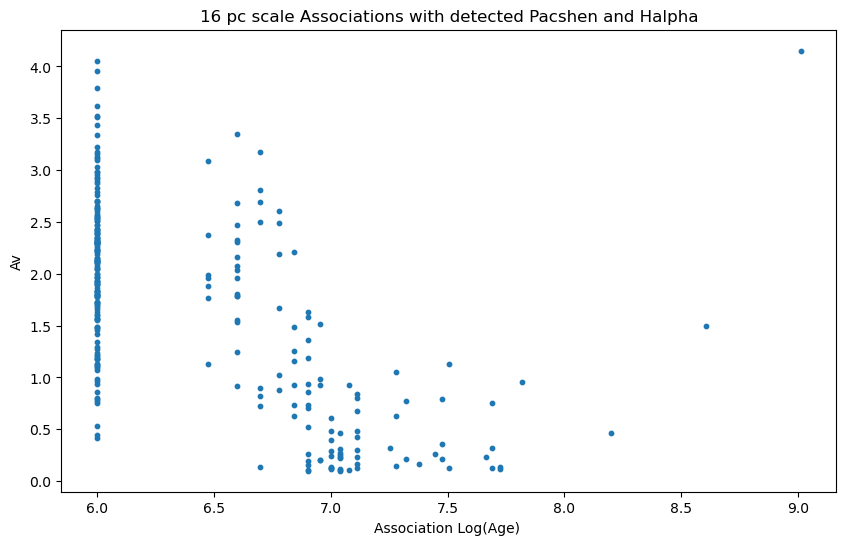

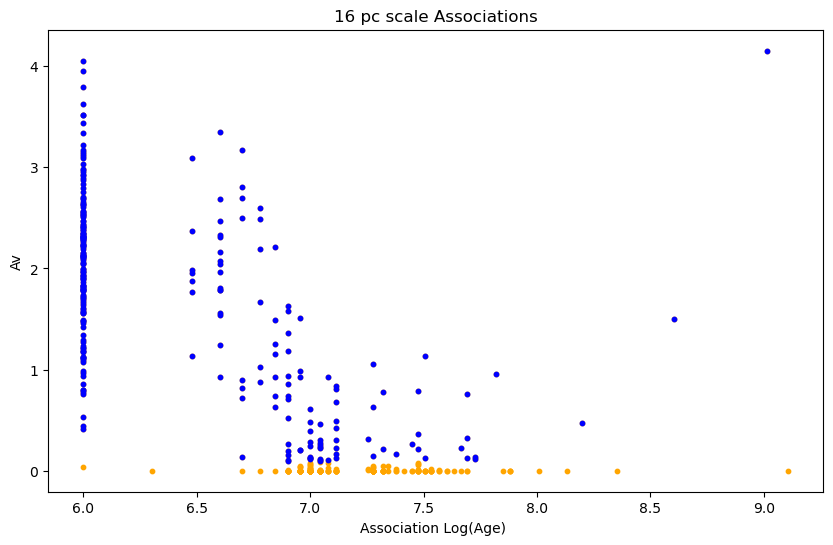

In [ ]:

plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
plt.scatter( association_age, v_diff[av_corrected], s=10)
#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16 pc scale Associations with detected Pacshen and Halpha')
plt.ylabel('Av')
plt.xlabel('Association Log(Age) ')

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_Av.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()
#_-------------------------------
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star']*1e6)
v_diff_all = (data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']) +cigale_df['bayes.attenuation.A550']
plt.scatter( association_age, v_diff, s=10,color='orange')
plt.scatter( association_age[av_corrected], v_diff[av_corrected], s=10,color='blue')
#plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.title('16 pc scale Associations')
plt.ylabel('Av')
plt.xlabel('Association Log(Age) ')

plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Age_totalAv.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

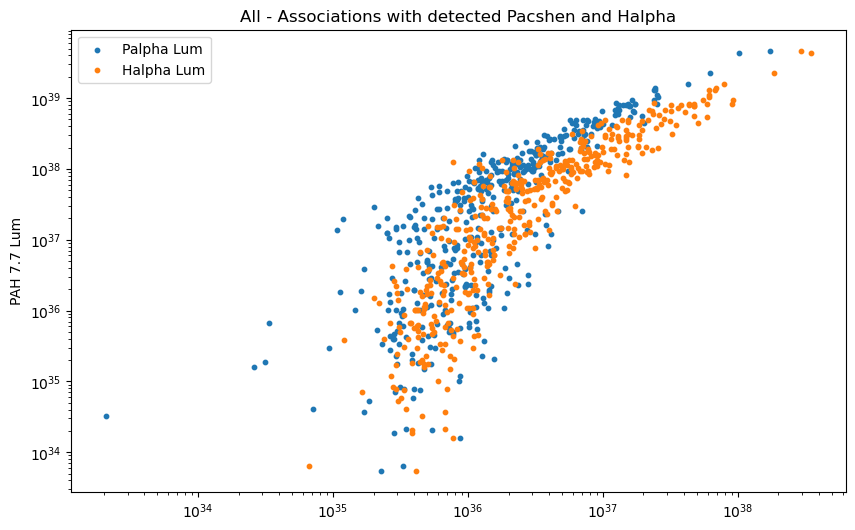

In [ ]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
Myr = np.log10(cigale_df['best.stellar.age_m_star']*1e6) < 6.2

#plt.scatter(covFrac_df['reg_Pa_alpha_Luminosity'][Myr], covFrac_df['reg_PAH7p7_Luminosity'][Myr], s=10, label='Palpha Lum')
#plt.scatter(covFrac_df['reg_H_alpha_Luminosity'][Myr], covFrac_df['reg_PAH7p7_Luminosity'][Myr], s=10, label = 'Halpha Lum')

plt.scatter(covFrac_df['reg_Pa_alpha_Luminosity'], covFrac_df['reg_PAH7p7_Luminosity'], s=10, label='Palpha Lum')
plt.scatter(covFrac_df['reg_H_alpha_Luminosity'], covFrac_df['reg_PAH7p7_Luminosity'], s=10, label = 'Halpha Lum')

plt.title('All - Associations with detected Pacshen and Halpha')
plt.ylabel('PAH 7.7 Lum')
#plt.xlabel('Halpha Lum ')

plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_Pa_Ha_PAH_Lum_all.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

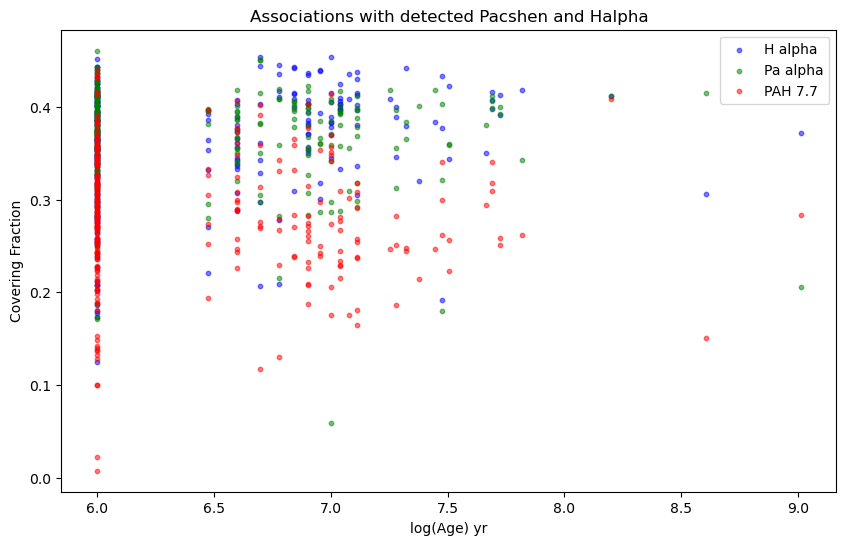

In [ ]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
Myr = np.log10(cigale_df['best.stellar.age_m_star']*1e6) < 6.2

plt.scatter(association_age,covFrac_df['reg_H_alpha_CDF_Covering_Fraction'][av_corrected],color='blue', s=10,alpha=0.5,label='H alpha')
plt.scatter(association_age,covFrac_df['reg_Pa_alpha_CDF_Covering_Fraction'][av_corrected],color='green', s=10,alpha=0.5,label = 'Pa alpha')
plt.scatter(association_age,covFrac_df['reg_PAH7p7_CDF_Covering_Fraction'][av_corrected],color='red', s=10,alpha=0.5, label='PAH 7.7')

#plt.scatter(covFrac_df['reg_H_alpha_CDF_Covering_Fraction'][Myr], covFrac_df['reg_Pa_alpha_CDF_Covering_Fraction'][Myr],color='blue', s=10,alpha=0.5,label='1-3 Myr associations')

plt.title('Associations with detected Pacshen and Halpha')
plt.xlabel('log(Age) yr')
plt.ylabel('Covering Fraction' )
plt.legend()
#plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_covFrac.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()

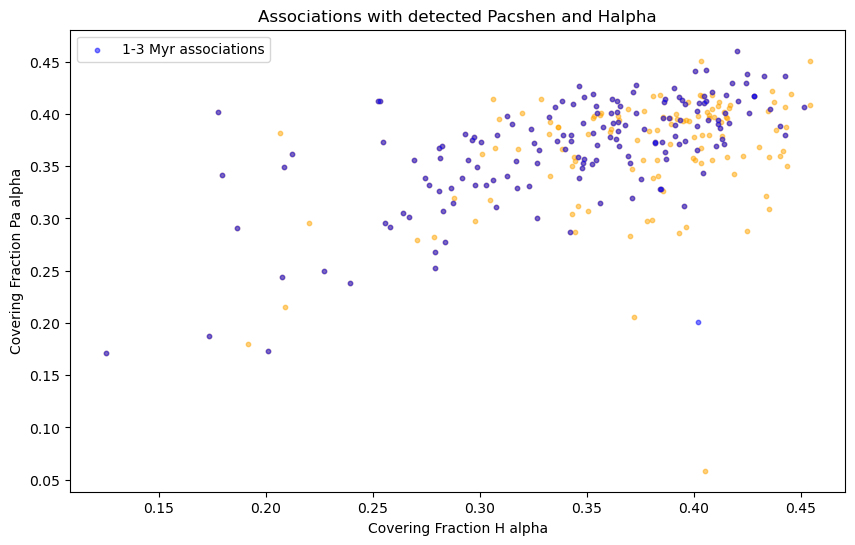

In [ ]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6)
v_diff = data_tbl['V_dolmag_vega_old']-data_tbl['V_dolmag_vega']
Myr = np.log10(cigale_df['best.stellar.age_m_star']*1e6) < 6.2

plt.scatter(covFrac_df['reg_H_alpha_CDF_Covering_Fraction'][av_corrected], covFrac_df['reg_Pa_alpha_CDF_Covering_Fraction'][av_corrected],color='orange', s=10,alpha=0.5)
plt.scatter(covFrac_df['reg_H_alpha_CDF_Covering_Fraction'][Myr], covFrac_df['reg_Pa_alpha_CDF_Covering_Fraction'][Myr],color='blue', s=10,alpha=0.5,label='1-3 Myr associations')

plt.title('Associations with detected Pacshen and Halpha')
plt.ylabel('Covering Fraction Pa alpha')
plt.xlabel('Covering Fraction H alpha')
plt.legend()
plt.savefig(fig_dir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_covFrac.pdf', bbox_inches='tight', pad_inches=0.15)

plt.show()


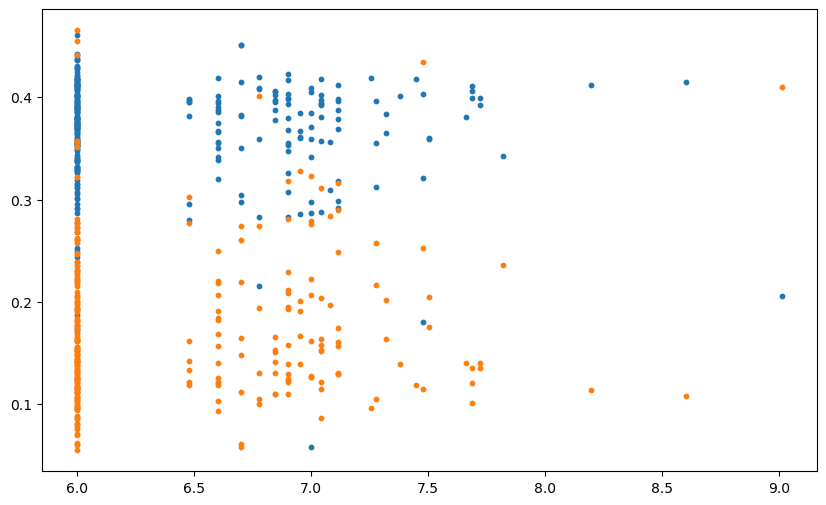

In [ ]:
plt.figure(figsize=(10, 6))
association_age = np.log10(cigale_df['best.stellar.age_m_star'][av_corrected]*1e6)
plt.scatter( association_age, covFrac_df['reg_Pa_alpha_Gini'][av_corrected], s=10)

plt.show()

In [38]:
age_bins = [6.0, 6.477, 6.699, 7.0, 7.477, 9.5] # 1Myr, 3Myr, 5Myr, 10Myr, 30Myr, max_age

test_bins = pd.cut(np.log10(data_reg_tbl['reg_dolflux_Age_MinChiSq']*1e6), bins=age_bins, labels=False, right=False)

#plt.figure(figsize=(10, 6))
#plt.violinplot(test_bins, showmedians=True)
print(test_bins)
test_bins.size

[2 4 3 2 3 3 3 3 3 3 3 2 2 3 2 2 3 3 3 3 3 3 2 4 3 3 3 3 4 3 3 3 3 3 3 3 3
 3 4 2 3 3 4 3 2 3 2 4 3 3 4 3 4 4 4 4 4 3 3 4 3 1 3 4 3 4 3 4 1 2 2 2 2 3
 3 3 2 3 3 3 3 3 3 2 1 3 1 2 3 2 2 3 3 3 3 3 3 4 3 3 3 1 3 2 3 3 1 2 3 2 3
 2 2 1 3 4 1 2 4 4 3 4 3 0 2 3 3 2 2 3 2 2 3 2 3 2 2 3 2 2 2 2 2 2 3 3 3 2
 2 4 3 3 4 3 3 1 3 3 3 3 3 3 3 3 3 4 2 3 4 0 4 2 3 2 0 3 3 2 3 4 2 1 0 1 0
 1 3 2 2 2 4 2 0 3 1 4 0 2 4 4 3 2 3 2 2 3 0 2 2 0 3 1 2 4 3 3 3 4 2 0 3 2
 0 3 2 2 2 2 3 2 2 1 3 0 4 4 2 3 4 2 3 4 2 4 3 2 2 3 2 2 4 4 3 3 2 1 3 3 2
 4 4 3 2 2 4 3 2 2 2 0 0 0 3 3 4 3 4 3 3 2 1 4 3 4 0 2 3 3 2 3 1 3 0 2 2 3
 4 2 4 2 3 3 3 4 2 3 0 2 3 3 3 4 2 3 3 3 2 1 2 2 2 3 3 1 2 2 2 3 3 3 2 2 4
 2 3 2 4 4 3 0 4 1 1 0 2 4 4 2 1 4 0 3 3 4 2 3 0 3 3 2 2 2 2 2 3 3 3 2 2 4
 2 0 3 2 4 3 4 2 3 2 3 2 3 4 2 3 2 3 2 4 2 3 2 4 4 3 3 3 2 4 2 3 2 3 4 3 0
 2 4 4 3 3 2 2 2 3 3 2 3 2 3 3 4 4 2 2 3 3 3 4 3 3 3 3 4 4 3 3 4 3 3 3 4 3
 3 3 4 3 3 4 3 3 3 3]


454

In [37]:
print(np.log10(1e6),np.log10(3e6),np.log10(5e6),np.log10(7e6),np.log10(10e6),np.log10(20e6),np.log10(30e6),np.log10(50e6),np.log10(100e6),np.log10(200e6),np.log10(300e6),np.log10(500e6),np.log10(1000e6))

6.0 6.477121254719663 6.698970004336019 6.845098040014257 7.0 7.301029995663981 7.477121254719663 7.698970004336019 8.0 8.301029995663981 8.477121254719663 8.698970004336019 9.0


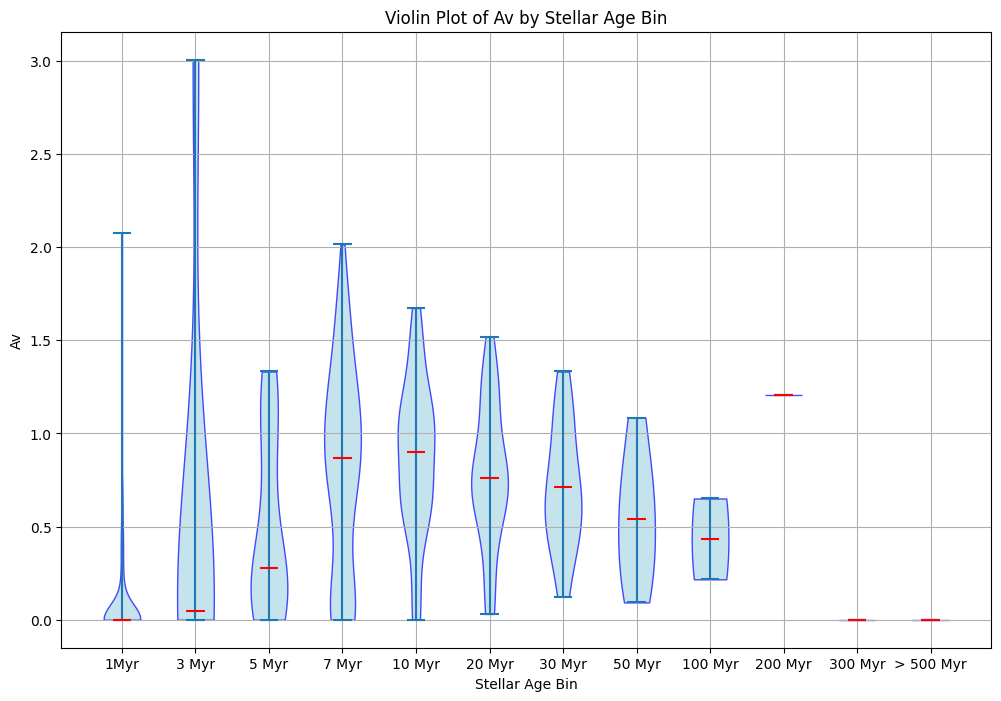

In [40]:
# Create bins for age
#age_bins = [6.0, 6.47, 6.699, 6.5,7.0, 7.477, 9.5] # 1Myr, 3Myr, 5Myr, 10Myr, 30Myr, max_age
#age_labels = ['<1Myr', '3-5Myr', '5-7Myr','7-10Myr', '10-30Myr', '>30Myr']

age_labels = ['1Myr', '3 Myr', '5 Myr','7 Myr', '10 Myr', '20 Myr', '30 Myr', '50 Myr', '100 Myr', '200 Myr', '300 Myr', '> 500 Myr']

n_bins = 12

# Bin the stellar age data
cigale_df['age_bin'] = pd.cut(np.log10(cigale_df['best.stellar.age_m_star']*1e6), bins=n_bins, labels=age_labels, right=False)

# Create a list of Av values for each age bin
av_data_by_age_bin = [cigale_df[cigale_df['age_bin'] == label]['best.attenuation.A550'].dropna() for label in age_labels]

# Create the violin plot
plt.figure(figsize=(12, 8))
violin_parts = plt.violinplot(av_data_by_age_bin, showmedians=True)

# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks(np.arange(1, len(age_labels) + 1), age_labels)
plt.ylabel('Av')
plt.xlabel('Stellar Age Bin')
plt.title('Violin Plot of Av by Stellar Age Bin')
plt.grid(True)
plt.show()

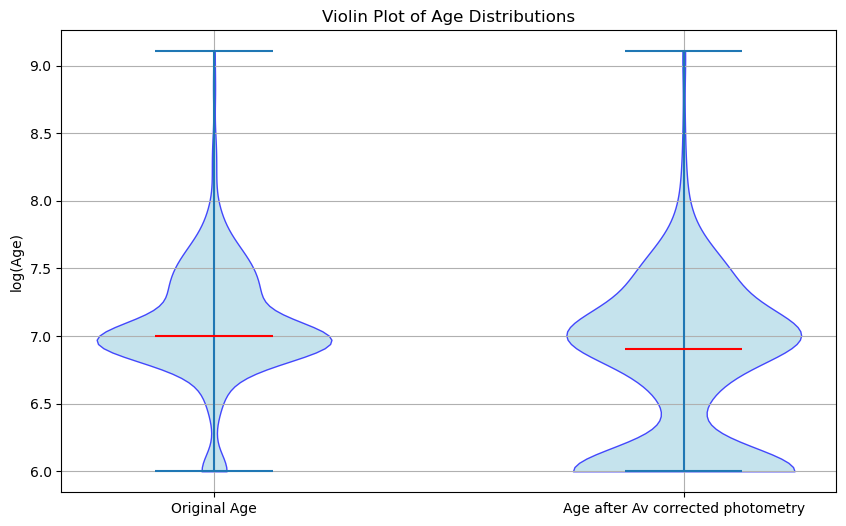

In [ ]:
plt.figure(figsize=(10, 6))
# Create a list of data to plot
data_to_plot = [np.log10(data_reg_tbl['reg_dolflux_Age_MinChiSq']*1e6),
                np.log10(cigale_df['best.stellar.age_m_star']*1e6)]

# Create the violin plot
violin_parts = plt.violinplot(data_to_plot, showmedians=True)

# Customize the appearance of the violin plot (optional)
for body in violin_parts['bodies']:
    body.set_facecolor('lightblue')
    body.set_edgecolor('blue')
    body.set_alpha(0.7)

# Customize the median line (optional)
violin_parts['cmedians'].set_edgecolor('red')

# Set labels and title
plt.xticks([1, 2], ['Original Age', 'Age after Av corrected photometry'])
plt.ylabel('log(Age)')
plt.title('Violin Plot of Age Distributions')
plt.grid(True)
plt.show()

## Old pipe3 code


In [ ]:
def phangs_cigale_pipe3(self):
		"""Function to fit SEDs, with CIGALE, to associations

		Inputs
		------
		Distance file
		reginfo (pipe1)
		dolphot photometry (pipe2)

		Returns
		-------
		total_runtime: 'float'
			Runtime for step 3 of pipeline

		Notes
		-----
		7/6/22: JWL - config_dict can't be read by pcigale to make pcigale.ini and proceed
				JWL - works if you run 3rd step of Phangs_wshierarchy_main.py though
		7/22/22: JWL - pipe3 works now. Pipeline must be run from appropriate directory for your CIGALE installation to be recognized
		"""
		# ------------------------------
		#  Define CIGALE output folder
		# ------------------------------
		cigdir = 'out/'
		cigale_file = 'results'
		cigdir_new = self.outdir+'Cigale_outs/'
		bayes_output_path = cigdir_new+'bayesian_analysis_output/'
		# -------
		infile_SSP=datadir+'models-block-bc03-0cov.txt'

		# ------------------------------
		#   check for output directory
		# ------------------------------
		if (path.exists(cigdir_new)==True):
		    print('Output directory: '+cigdir_new +' already exists')
		if (path.exists(cigdir_new)==False):
		    os.mkdir(cigdir_new)
		    print("Output Directory '% s' created" % cigdir_new)
		# ------------------------------

		# JWL: Initialize CIGALE stats file
		statfile_name = '{0}{1}_{2}_hpfilt{3}_Cigale_stats.txt'.format(cigdir_new,self.gal,self.tracer_band,self.filter_step)
		#statfile_name = cigdir_new+gal+'_'+tracer_band+'_hpfilt'+filter_step+'_Cigale_stats.txt'
		statfile = open(statfile_name,'w')
		statfile.write(cigdir_new+'\n')
		statfile.write('Galaxy:  {0}\n'.format(self.gal))
		statfile.write('Dolphot file:  {0}\n'.format(self.dolphot_combfile))
		statfile.write('Tracer star band: {0}\n'.format(self.tracer_band))
		statfile.write('Smoothing step: {0}\n'.format(self.filter_step))

		# JWL: Begin tracking runtime
		program_start_time = time.time()

		#---------------------------------
		# check the distance and re-set scale levels
		# Cigale step will fail is there are no regions at a given level.
		pc_scales = ['8','16','32','64']
		n_scales = len(pc_scales)
		if (self.distmpc > 17.0):
		    pc_scales = ['16','32','64']
		    n_scales = len(pc_scales)
		    min_scale_pc = 16 # minimum scale length set in parsecs
		    nlevels = n_scales #number of hierarchy levels to compute

		#-------------------------------------#-------------------------------------#-------------------------------------
		#-------------------------------------#-------------------------------------#-------------------------------------
		#read in model data
		#;;--------
		#;; BC03 models
		#readcol,'models-block-bc03-0cov.txt',
		#format='(i,d,d,d,d,d,d,d,d,d,d,d,d,d,d,d)',bc03id ,bc03F275W_1 ,bc03F275W_2 ,bc03F336W_1 ,bc03F336W_2 ,bc03F435W_acs ,
		#bc03F438W_1 ,bc03F438W_2 ,bc03F555W_ACS ,bc03F555W_1 ,bc03F555W_2 ,bc03F814W_ACS ,bc03F814W_1 ,bc03F814W_1 ,bc03mstar,bc03age
		#;; convert mjy to vega mag
		#infile_SSP='models-block-bc03-0cov.txt'
		#bc03=pd.read_csv(infile_SSP, header=0,converters={'clumpSFRerr':np.float,'age_err':np.float,'mass_err':np.float}, delim_whitespace= True)
		bc03=pd.read_csv(infile_SSP, header=0, delim_whitespace= True)

		#filter_list = ['F336W', 'F435W', 'F555W', 'F814W']
		#ab_zp = [24.52, 25.689, 25.68, 24.99]
		#vega_zp = [23.34, 25.784, 25.71, 24.57]

		filter_list = ['F336W', 'F438W', 'F555W', 'F814W']
		ab_zp = [24.7074, 24.8565, 25.8242, 25.1399]
		vega_zp = [23.5265, 24.9940, 25.8325, 24.6980]

		bc03_U_ab = -2.5 * np.log10( bc03['F336W_UVIS_CHIP2']* np.power(10.,-29) ) - 48.60
		bc03_U_vega = bc03_U_ab + (vega_zp[0] - ab_zp[0])

		bc03_B_ab = -2.5 * np.log10( bc03['F438W_UVIS_CHIP2']*np.power(10.,-29) ) -48.60
		bc03_B_vega = bc03_B_ab + (vega_zp[1] - ab_zp[1])

		bc03_V_ab = -2.5 * np.log10( bc03['F555W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
		bc03_V_vega = bc03_V_ab + (vega_zp[2] - ab_zp[2])

		bc03_I_ab = -2.5 * np.log10( bc03['F814W_UVIS_CHIP2']* np.power(10.,-29) ) -48.60
		bc03_I_vega = bc03_I_ab + (vega_zp[3] - ab_zp[3])
		#;;--------

		#read in combined dolphot + region info table
		#i=0
		statfile.write('pc level, med Age (.25Q,.75Q), med Mass (.25Q,.75Q), med E(B-V) (.25Q,.75Q), med nDolphot (.25Q,.75Q), med NUV dolMag (.25Q,.75Q), med M_V abs(Mag) (.25Q,.75Q) \n')

		for i in range(nlevels):

			#cig_input_file = '{0}_{1}_ws{2}pc_hpfilt{3}_Dolphot_mjy_cigfile.tab'.format(self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))

			#cig_input_file = self.gal+'_'+self.tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(self.filter_step)+'_Dolphot_mjy_cigfile.tab'
			#print(self.outdir2+cig_input_file)
			#cig_input = pd.read_csv(self.outdir2+cig_input_file,sep=' ')
			cig_input_file = self.gal+'_'+self.tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(self.filter_step)+'_Dolphot_mjy_cigfile.tab'
			cig_input = pd.read_csv(self.outdir2+cig_input_file,sep=' ')
			cig_input_col = list(cig_input.columns.values)
			cig_input_filters = cig_input_col[3:13]
			print(cig_input_filters)
			print([cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
						                                             cig_input_filters[8]])
			datafile_name = '{0}{1}_nuv_ws{2}.fits'.format(self.outdir,self.gal,pc_scales[i])
			#datafile_name =outdir+gal+'_nuv_ws'+pc_scales[i]+'.fits'
			#gal_data_tbl = Table.read(datafile_name, format='fits')

			reginfo_file = '{0}{1}_{2}_ws{3}pc_hpfilt{4}_reginfo.fits'.format(self.outdir,self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))
			#reginfo_file = outdir+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(filter_step)+'_reginfo.fits'
			#reginfo_tbl = fits.getdata(reginfo_file,1)
			reginfo_tbl = Table.read(reginfo_file, format='fits')
			reginfo_df = reginfo_tbl.to_pandas()

			#df = tbl.to_pandas()
			#print(len(df.regID))
			photfile = '{0}{1}_{2}_ws{3}pc_hpfilt{4}_Dolphot.fits'.format(self.outdir2,self.gal,self.tracer_band,pc_scales[i],str(self.filter_step))
			#photfile = outdir2+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(filter_step)+'_Dolphot'+'.fits'
			phot_tbl = Table.read(photfile, format='fits')
			phot_df = phot_tbl.to_pandas()

			#------------------------------------
			#change fitting to CHIP1
			config_dict = {'data_file': self.outdir2+cig_input_file,
		                       'parameters_file': '', 'sed_modules': ['sfh2exp', 'bc03', 'dustext', 'redshifting'],
		                       'analysis_method': 'pdf_analysis', 'cores': 8,
		                       'bands': cig_input_filters, 'properties': [],
		                       'sed_modules_params': {'sfh2exp': {'tau_main': [0.001], 'tau_burst': [0.001], 'f_burst': [0.0],
		                                                              'age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
		                                                                          14, 15, 16, 18, 19, 21, 22, 24, 26, 28, 30,
		                                                                          32, 34, 37, 40, 43, 46, 49, 53, 57, 61, 66,
		                                                                          71, 76, 82, 88, 95, 102, 110, 118, 127, 136,
		                                                                          147, 158, 169, 182, 196, 210, 226, 243, 261,
		                                                                          281, 302, 324, 349, 375, 403, 433, 465, 500,
		                                                                          537, 577, 621, 667, 717, 770, 828, 890, 956,
		                                                                          1028, 1105, 1187, 1276, 1371, 1474, 1584,
		                                                                          1702, 1829, 1966, 2113, 2271, 2440, 2623,
		                                                                          2819, 3029, 3255, 3499, 3760, 4041, 4343,
		                                                                          4667, 5015, 5390, 5793, 6225, 6690, 7190,
		                                                                          7727, 8304, 8925, 9591, 10308, 11077,
		                                                                          11905, 12794, 13750],
		                                                              'burst_age': [1], 'sfr_0': [1.0], 'normalise': True},
		                                                  'bc03': {'imf': [1], 'metallicity': [0.02], 'separation_age': [10]},
		                                                  'dustext': {'E_BV': [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07,
		                                                                           0.08, 0.09, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15,
		                                                                           0.16, 0.17, 0.18, 0.19, 0.2, 0.21, 0.22, 0.23,
		                                                                           0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3, 0.31,
		                                                                           0.32, 0.33, 0.34, 0.35000000000000003, 0.36, 0.37,
		                                                                           0.38, 0.39, 0.4, 0.41000000000000003, 0.42, 0.43,
		                                                                           0.44, 0.45, 0.46, 0.47000000000000003, 0.48, 0.49, 0.5,
		                                                                           0.51, 0.52, 0.53, 0.54, 0.55, 0.56, 0.5700000000000001,
		                                                                           0.58, 0.59, 0.6, 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
		                                                                           0.67, 0.68, 0.6900000000000001, 0.7000000000000001,
		                                                                           0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79,
		                                                                           0.8, 0.81, 0.8200000000000001, 0.8300000000000001, 0.84,
		                                                                           0.85, 0.86, 0.87, 0.88, 0.89, 0.9, 0.91, 0.92, 0.93,
		                                                                           0.9400000000000001, 0.9500000000000001, 0.96, 0.97,
		                                                                           0.98, 0.99, 1.0, 1.01, 1.02, 1.03, 1.04, 1.05, 1.06,
		                                                                           1.07, 1.08, 1.09, 1.1, 1.11, 1.12, 1.1300000000000001,
		                                                                           1.1400000000000001, 1.1500000000000001, 1.16, 1.17,
		                                                                           1.18, 1.19, 1.2, 1.21, 1.22, 1.23, 1.24, 1.25, 1.26,
		                                                                           1.27, 1.28, 1.29, 1.3, 1.31, 1.32, 1.33, 1.34, 1.35, 1.36,
		                                                                           1.37, 1.3800000000000001, 1.3900000000000001,
		                                                                           1.4000000000000001, 1.41, 1.42, 1.43, 1.44, 1.45,
		                                                                           1.46, 1.47, 1.48, 1.49, 1.5], 'Rv': [3.1], 'law': [0],
		                                                                  'filters': cig_input_filters[0]+' & '+cig_input_filters[2]+' & '+cig_input_filters[4]+' & '+
		                                                                  cig_input_filters[6]+' & '+cig_input_filters[8]},
		                                                  'redshifting': {'redshift': [0.0]}},
		                       'analysis_params': {'variables': ['stellar.age', 'stellar.m_star', 'attenuation.E_BV', 'sfh.age'],
		                                               'bands': [cig_input_filters[0], cig_input_filters[2], cig_input_filters[4], cig_input_filters[6],
		                                                             cig_input_filters[8]],
		                                                             'save_best_sed': True, 'save_chi2': 'all', 'lim_flag': False,
		                                               'mock_flag': False, 'redshift_decimals': 2, 'blocks': 1}}
			#-------------------------------------#-------------------------------------#-------------------------------------
			#
			pdf = PdfAnalysis()
			pdf.process(config_dict)
			#-------------------------------------#-------------------------------------

			#copy cigale output to data output dir.
			#cigale_new_file = cigdir_new+gal+'_ws'+scales[i]+'_cig_results'

			cigale_new_file = cigdir_new+gal+'_'+tracer_band+'_ws'+pc_scales[i]+'pc_hpfilt'+str(filter_step)+'_cig_results'

			#os.system('cp '+cigdir+cigale_file+'.fits '+cigale_new_file+'.fits')
			#os.system('cp '+cigdir+cigale_file+'.txt '+cigale_new_file+'.txt')
			#os.system('cp '+cigdir+'observations.txt '+cigdir_new )
			#os.system('cp '+cigdir+'observations.fits '+cigdir_new )


			#in Myr( *10^6) for ages
			#in units of Msolar

			#-------------------------------------#-------------------------------------
			#        Read in cigale data
			#cigale=fits.getdata(cigdir+cigale_file+'.fits')
			#cigale.dtype

			cigale_tbl = Table.read(cigdir+cigale_file+'.fits', format='fits')
			cigale_df = cigale_tbl.to_pandas()

			#-------------------------------------#-------------------------------------#-------------------------------------
			#sinan ERROR code:
			age_error, mass_error, ebv_error = [], [], []

			for sed_object_index, sed_object_regID in enumerate(reginfo_df['regID'].values):
				#print(sed_object_index, sed_object_regID)

				age_file = 'out/'+str(sed_object_regID)+'_sfh.age_chi2-block-0.npy'
				mass_file = 'out/'+str(sed_object_regID)+'_stellar.m_star_chi2-block-0.npy'
				ebv_file = 'out/'+str(sed_object_regID)+'_attenuation.E_BV_chi2-block-0.npy'

				if (path.exists(age_file) & path.exists(mass_file) & path.exists(ebv_file)):
					models, pdf, generated_red_chi2 = self.read_data(age_file, mass_file, ebv_file, return_red_chi2=True)
					age_1sigma, mass_1sigma, ebv_1sigma = self.calc_chi2_uncertainty(models[:, 0], models[:, 1], models[:, 2], generated_red_chi2)

					age_error.append(age_1sigma)
					mass_error.append(mass_1sigma)
					ebv_error.append(ebv_1sigma)
				else:
					age_error.append(np.NAN)
					mass_error.append(np.NAN)
					ebv_error.append(np.NAN)

			"""KEEP MASS-AGE-EBV WITH 3 SIGNIFICANT FIGURES"""
			cigale_df['reg_dolflux_Age_MinChiSq_err'] = np.round(age_error, 3)
			cigale_df['reg_dolflux_Mass_MinChiSq_err'] = np.round(mass_error, 3)
			cigale_df['reg_dolflux_Ebv_MinChiSq_err'] = np.round(ebv_error, 3)

			#-----------
			#save cigale output to data table
			#-----------
			cigale_df.to_csv(cigale_new_file+'.csv')
			new_cigale_tbl = Table.from_pandas(cigale_df)
			new_cigale_tbl.write(cigale_new_file+'.fits',overwrite=True)

			#-----------
			shutil.move(cigdir+'observations.txt',cigdir_new+'observations.txt')
			shutil.move(cigdir+'observations.fits',cigdir_new+'observations.fits')

			#os.system('cp '+cigdir+cigale_file+'.fits '+cigale_new_file+'.fits')
			#os.system('cp '+cigdir+cigale_file+'.txt '+cigale_new_file+'.txt')
			#os.system('cp '+cigdir+'observations.txt '+cigdir_new )
			#os.system('cp '+cigdir+'observations.fits '+cigdir_new )

			#-------------------------------------#-------------------------------------#-------------------------------------
			#"""Call to Jordan Turner's Bayesian Priors analysis here"""

			#   ---------------      ADD Bayesian CODE HERE      ---------------   #

			#-------------------------------------#-------------------------------------#-------------------------------------
			#If using mac or linux can remove cigale directory when done.
			# Will NOT run on a windows OS
			#remove cigale directory
			os.system('rm -r '+cigdir)

			#------------------------------------    #------------------------------------    #------------------------------------
			g_mass = (np.log10(cigale_tbl['best.stellar.m_star']) > 0 )
			Mv = phot_df.v_dolmag - self.dist_mod

			#Check for Inf
			Mv[(Mv==np.inf)] = np.NAN
			phot_df.nuv_dolmag[(phot_df.nuv_dolmag==np.inf)] = np.NAN

			print(pc_scales[i]+'pc, '+str((np.nanmedian(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6))) )
				+' ('+str((np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .25)))+','
				+str((np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .75)))+') &'
				+str((np.nanmedian(np.log10(cigale_df['best.stellar.m_star'][g_mass]))))
				+' ('+str((np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .25)))+','+str((np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .75)))+') &'
				+str((np.nanmedian(cigale_df['best.attenuation.E_BV'][g_mass])))
				+' ('+str((np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .25)))+','+str((np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .75)))+') &'
				+str((np.nanmedian(phot_df.ndolphot)))+' ('+str((np.nanquantile(phot_df.ndolphot, .25)))+','+str((np.nanquantile(phot_df.ndolphot, .75)))+') &'
				+str((np.nanmedian(phot_df.nuv_dolmag)))+' ('+str((np.nanquantile(phot_df.nuv_dolmag, .25)))+','+str((np.nanquantile(phot_df.nuv_dolmag, .75)))+') &'
				+str((np.nanmedian(Mv)))+' ('+str((np.nanquantile(Mv, .25)))+','+str((np.nanquantile(Mv, .75)))+') '
				)

			#------------------------------------    #------------------------------------    #------------------------------------
			#       Save stats
			#------------------------------------
			#g_mass = (np.log10(cigale_tbl['best.stellar.m_star']) > 0 )
			#Mv = phot_df.v_dolmag - dist_mod
			# med reddening, ndolphot,med '+tracer_band+'(.25Q,.75Q)   \n')
			statfile.write(pc_scales[i]+'pc, '+str(self.round_sig(np.nanmedian(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6))) )
						+' ('+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .25)))+','
						+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.age_m_star'][g_mass]*1e6), .75)))+') &'
						+str(self.round_sig(np.nanmedian(np.log10(cigale_df['best.stellar.m_star'][g_mass]))))
						+' ('+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .25)))+','
						+str(self.round_sig(np.nanquantile(np.log10(cigale_df['best.stellar.m_star'][g_mass]), .75)))+') &'
						+str((np.nanmedian(cigale_df['best.attenuation.E_BV'][g_mass])))
						+' ('+str(np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .25))
						+','+str(np.nanquantile(cigale_df['best.attenuation.E_BV'][g_mass], .75))+') &'
						+str(self.round_sig(np.nanmedian(phot_df.ndolphot)))+' ('+str(self.round_sig(np.nanquantile(phot_df.ndolphot, .25)))
						+','+str(self.round_sig(np.nanquantile(phot_df.ndolphot, .75)))+') &'
						+str(self.round_sig(np.nanmedian(phot_df.nuv_dolmag)))+' ('+str(self.round_sig(np.nanquantile(phot_df.nuv_dolmag, .25)))
						+','+str(self.round_sig(np.nanquantile(phot_df.nuv_dolmag, .75)))+') &'
						+str(self.round_sig(np.nanmedian(Mv)))+' ('+str(self.round_sig(np.nanquantile(Mv, .25)))+','+str(self.round_sig(np.nanquantile(Mv, .75)))+') '
						+' \n' )

			#------------------------------------    #------------------------------------    #------------------------------------
			#Save combined datafile
			#--------------------------------
			t_comb =Table([reginfo_df['regID'],reginfo_df['peak_xpos'],reginfo_df['peak_ypos'],reginfo_df['peak_ra'],reginfo_df['peak_dec'],reginfo_df['area_pc'],reginfo_df['rad_pc'],
							phot_df.nuv_dolflux_mjy, phot_df.nuv_dolflux_mjy_err ,phot_df.u_dolflux_mjy,phot_df.u_dolflux_mjy_err, phot_df.b_dolflux_mjy, phot_df.b_dolflux_mjy_err,
							phot_df.v_dolflux_mjy, phot_df.v_dolflux_mjy_err, phot_df.i_dolflux_mjy, phot_df.i_dolflux_mjy_err,
							phot_df.nuv_dolmag, phot_df.nuv_dolmagUnc, phot_df.u_dolmag, phot_df.u_dolmagUnc, phot_df.b_dolmag, phot_df.b_dolmagUnc,
							phot_df.v_dolmag, phot_df.v_dolmagUnc, phot_df.i_dolmag, phot_df.i_dolmagUnc,
							cigale_df['best.stellar.age_m_star'], cigale_df['reg_dolflux_Age_MinChiSq_err'],
							cigale_df['best.stellar.m_star'], cigale_df['reg_dolflux_Mass_MinChiSq_err'],
							cigale_df['best.attenuation.E_BV'], cigale_df['reg_dolflux_Ebv_MinChiSq_err'], cigale_df['best.reduced_chi_square']
		                        ],
							names=('reg_id','reg_x','reg_y','reg_ra','reg_dec','reg_area','reg_rad',
		                             'NUV_dolflux_mjy','NUV_dolflux_mjy_err','U_dolflux_mjy','U_dolflux_mjy_err','B_dolflux_mjy','B_dolflux_mjy_err',
		                             'V_dolflux_mjy','V_dolflux_mjy_err','I_dolflux_mjy', 'I_dolflux_mjy_err',
		                             'NUV_dolmag_vega','NUV_dolmag_vega_err','U_dolmag_vega','U_dolmag_vega_err',
		                             'B_dolmag_vega','B_dolmag_vega_err','V_dolmag_vega','V_dolmag_vega_err',
									 'I_dolmag_vega','I_dolmag_vega_err',
		                             'reg_dolflux_Age_MinChiSq','reg_dolflux_Age_MinChiSq_err',
		                             'reg_dolflux_Mass_MinChiSq','reg_dolflux_Mass_MinChiSq_err',
		                             'reg_dolflux_Ebv_MinChiSq', 'reg_dolflux_Ebv_MinChiSq_err','reg_dolflux_ChiSq_Reduced'),
							meta={'ws_data':gal+' tracer band:'+tracer_band+'scale level [pc]:'+pc_scales[i] })

			combfile = '{0}_phangshst_associations_{1}_ws{2}pc_v1'.format(self.gal,self.tracer_band,pc_scales[i])
			#combfile = gal+'_phangshst_associations_'+tracer_band+'_ws'+pc_scales[i]+'pc_v1'
			#os.system('rm '+outdir2+photfile+'.fits')
			fits.writeto(self.outdir2+combfile+'.fits', np.array(t_comb),overwrite=True)
			df_comb = t_comb.to_pandas()
			df_comb.to_csv(self.outdir2+combfile+'.csv')
			print(self.outdir2+combfile+'.csv written' )
			#------------------------------------

			#--------------------------------
		statfile.close()
		#--------------------------------
		print('%s --- Cigale(pipe3) finished...' % gal)

		total_runtime = (time.time() - program_start_time)/60.0
		print("%s --- Total time --- %.2f seconds (%.2f minutes) ---" % (gal,time.time() - program_start_time,total_runtime))

		return(np.round(total_runtime,2))

## Sinan's cluster pipeline

In [ ]:
'''
#Implemented: 15 March 2022

import sys
import os
from os import path
import shutil
import datetime
"""Import the basics; numpy, pandas, matplotlib et al."""
import pandas as pd
import numpy as np
"""Import CIGALE"""
import pcigale
from pcigale.analysis_modules.pdf_analysis import PdfAnalysis


def cigale_sed_fit(data_df, galaxy_props_dictionary, fit_specs_dictionary,
                   id_str, transfer_files=False, **fitargs):

    """
    This function takes the output from the daoaugment + candidateselect part of the pipeline as its input, and follows these steps:

    Performs the SED fitting with CIGALE, and outputs the result to sed_fit_output_path

   :param   data_df: should have the photometry in mJy, with the column names in the format compatible with CIGALE filter definitions
            galaxy_props_dictionary: a dictionary containing the properties of the target galaxy. the default setup contains following keys;
                galaxy_id: galaxy id in the "ngc0000" format, as given in [pipeline list] within cluster_detection_main.py
                galaxy_distance: distance of the target, as given in target_properties.py
                galaxy_redshift: 0.0 for all PHANGS-HST targets
                galaxy_filters: list/array containing the set of filters on which the SED fitting will be performed. The format
                for these needs to be as F---W_UVIS_CHIP2 for WFC3 filters, and F---W_ACS for ACS filters.
            fit_specs_dictionary: a dictionary containing the specifications of the SED fit. the default setup contains following keys;
                age: the list of ages of the models to be generated by CIGALE & used during the fitting.
                metallicity: the metallicity of the models.
                E_BV: a list containing the permissible reddening values to be used during the fitting.
                cores: How many CPU cores (threads, actually) to use for the fit. This has been known to cause issues, and it may need to be set to 1 irrespective
                of the specifications of the system where the code is being run.
            id_str: String denoting the column in data_df corresponding to unique object ID's.
            transfer_files: A boolean setting whether the SED fit result should be transferred to a new directory. By default, CIGALE will
            output the latest run to a folder named out in the current directory.
            fitargs: keyword arguments related to the fit. Current keys available are 'specific_run_tag' and 'sed_fit_output_path'.
            If transfer_files=True, these keys must also be supplied.
                specific_run_tag: Whether to name the folder where the SED fit results are transferred using the specs of the fit.
                If False, the name of the new folder will be 'latest_cigale_run'
                sed_fit_output_path: where the SED fit results will be transferred.

    Important Note: This implementation of the SED fitting requires all entries of the photometry to be CIGALE appropriate, i.e. no NaN/inf entries,
    -9999's in filters that won't be used in the fitting, negative error values for cases where fitting with upper limits is requested

    Important Note: The 'lim_flag' key needs to be set to 'lim_flag': True to trigger SED fitting with upper limits.

    """

    if transfer_files:

        sed_fit_output_path = fitargs['sed_fit_output_path']

        if not os.path.exists(sed_fit_output_path):
            os.makedirs(sed_fit_output_path)

    else:
        sed_fit_output_path = os.getcwd()

    """Get a list of filter id's without _err"""
    target_filters_without_err = [filt_raw for filt_raw in galaxy_props_dictionary['galaxy_filters'] if '_err' not in filt_raw]
    """Generate the CIGALE string needed for the dustext dictionary"""
    filt_str = ""
    for filt_ind, filt_id in enumerate(target_filters_without_err):
        if 'F814W' not in filt_id:
            filt_str += filt_id
            if 'F555W' not in filt_id:
                filt_str += ' & '

    """
    First, we generate the specific table CIGALE needs to perform the fitting.
    Below we add the galaxy ID, its distance, and its redshift as columns. This practically
    assumes that the SED fitting is performed on objects from the same galaxy.
    Then we generate a new data frame which only has these three plus the photometry & respective
    errors as its columns.
    """

    data_df['distance'] = galaxy_props_dictionary['galaxy_distance']
    data_df['redshift'] = galaxy_props_dictionary['galaxy_redshift']
    data_df['id'] = data_df[id_str]

    cols_to_copy = ['id', 'redshift', 'distance'] + galaxy_props_dictionary['galaxy_filters']
    data_df_to_fit = data_df[cols_to_copy].copy()
    """Output the data to be fit as an white-space separated table. CIGALE will read this file to perform the fitting"""
    data_df_to_fit.to_csv(sed_fit_output_path+'/'+galaxy_props_dictionary['galaxy_id']+'_detailed.tab', sep=' ', index=False)

    config_dict = {'data_file': sed_fit_output_path+'/'+galaxy_props_dictionary['galaxy_id']+'_detailed.tab',
                   'parameters_file': '', 'sed_modules': ['sfh2exp', 'bc03', 'dustext', 'redshifting'],
                   'analysis_method': 'pdf_analysis', 'cores': fit_specs_dictionary['cores'],
                   'bands': galaxy_props_dictionary['galaxy_filters'], 'properties': [], 'additionalerror': 0.05,
                   'sed_modules_params': {'sfh2exp': {'tau_main': [0.001], 'tau_burst': [0.001], 'f_burst': [0.0],
                                                      'age': fit_specs_dictionary['age'],
                                                      'burst_age': [1], 'sfr_0': [1.0], 'normalise': True},
                                          'bc03': {'imf': [1], 'metallicity': fit_specs_dictionary['metallicity'], 'separation_age': [10]},
                                          'dustext': {'E_BV': fit_specs_dictionary['E_BV'], 'Rv': [3.1], 'law': [0],
                                                      'filters': filt_str},
                                          'redshifting': {'redshift': [galaxy_props_dictionary['galaxy_redshift']]}},
                   'analysis_params': {'variables': ['stellar.age', 'stellar.m_star', 'attenuation.E_BV', 'sfh.age'],
                                       'bands': target_filters_without_err,
                                       'save_best_sed': True, 'save_chi2': 'all', 'lim_flag': 'full',
                                       'mock_flag': False, 'redshift_decimals': 2, 'blocks': 1}}

    """Perform the SED fitting"""
    pdf = PdfAnalysis()
    pdf.process(config_dict)

    """Move the SED fit results, if transfer_files=True"""

    """If wanting to move the files to folders names with the current date and time"""
    # current_datetime = str(datetime.datetime.now())
    # destination_path = sed_fit_output_path+'/cigale_fit_'+current_datetime

    if transfer_files:
        """The below routine will move the default CIGALE fit output folder titled 'out' """
        if fitargs['specific_run_tag']:
            """Generate a tag specific to the SED fit performed"""
            run_tag_init = galaxy_props_dictionary['galaxy_id']+'_E_BVmin_'+str(round(np.min(fit_specs_dictionary['E_BV']), 2)) + \
                           '_E_BVmax_'+str(round(np.max(fit_specs_dictionary['E_BV']), 2)) + \
                           '_Z'+str(fit_specs_dictionary['metallicity'][0])
            run_tag = run_tag_init.replace(".", "p")
            source_path = 'out'
            destination_path = sed_fit_output_path + '/' + run_tag

        else:
            source_path = 'out'
            destination_path = sed_fit_output_path + '/latest_cigale_run'

        if not os.path.exists(destination_path):
            os.makedirs(destination_path)

        copy_folder(source_path, destination_path)
        """Remove the SED fit results from the source path"""
        shutil.rmtree('out')


def copy_folder(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)


"""Example fit arguments -- The PHANGS-HST default SED fitting specs defined in Turner et al. 2020"""

# ebv_start = 0.0
# ebv_end = 1.5
# ebv_step = 0.01
# phans_def_ebv = np.arange(ebv_start, ebv_end+ebv_step, step=0.01)
#
# phangs_hst_default_fitspecs = {'age': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,
#                                        14, 15, 16, 18, 19, 21, 22, 24, 26, 28, 30,
#                                        32, 34, 37, 40, 43, 46, 49, 53, 57, 61, 66,
#                                        71, 76, 82, 88, 95, 102, 110, 118, 127, 136,
#                                        147, 158, 169, 182, 196, 210, 226, 243, 261,
#                                        281, 302, 324, 349, 375, 403, 433, 465, 500,
#                                        537, 577, 621, 667, 717, 770, 828, 890, 956,
#                                        1028, 1105, 1187, 1276, 1371, 1474, 1584,
#                                        1702, 1829, 1966, 2113, 2271, 2440, 2623,
#                                        2819, 3029, 3255, 3499, 3760, 4041, 4343,
#                                        4667, 5015, 5390, 5793, 6225, 6690, 7190,
#                                        7727, 8304, 8925, 9591, 10308, 11077,
#                                        11905, 12794, 13750],
#                                'metallicity': [0.02],
#                                'E_BV': phans_def_ebv,
#                                'cores': 8}
#
# galaxy_props_dict = {'galaxy_id': 'ngc1566',
#                      'galaxy_distance': 10.0,
#                      'galaxy_redshift': 0.0,
#                      'galaxy_filters': ['F---W_UVIS_CHIP2', 'F---W_UVIS_ACS']}  # see param list above


